In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# MEG modules

import mne

In [2]:
root_dir = '/Users/solmihkim/Downloads/datasci_125_data'

# params
subject = 'sub-001'
ses = 'ses-001'
# file paths
meg_path = '%s/%s/%s/meg/%s_%s_task-compr_meg.ds/' % (root_dir, subject, ses, subject, ses)
#meg_path = os.path.join(root_dir, subject, ses, 'meg', f'{subject}_{ses}_task-compr_meg.ds')

event_path = '%s/%s/%s/meg/%s_%s_task-compr_events.tsv' % (root_dir, subject, ses, subject, ses)

In [3]:
# load MEG data for this participant during this session
raw = mne.io.read_raw_ctf(meg_path)
# crop just the first 10 minutes
#raw.crop(0, 60*10)
# load the data into memory
raw.load_data()
print(raw)

ds directory : /Users/solmihkim/Downloads/datasci_125_data/sub-001/ses-001/meg/sub-001_ses-001_task-compr_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.65   67.90    0.00 mm <->   -0.65   67.90   -0.00 mm (orig :  -38.31   58.21 -232.55 mm) diff =    0.000 mm
       0.65  -67.90    0.00 mm <->    0.65  -67.90   -0.00 mm (orig :   58.69  -36.83 -232.48 mm) diff =    0.000 mm
      78.39    0.00    0.00 mm <->   78.39    0.00    0.00 mm (orig :   65.52   66.09 -236.18 mm) diff =    0.000 mm
    Coordinate transformations established.
No date or time found, setting to the start of the POSIX epoch (1970/01/01 midnight)
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 8 EEG channels from channel info
    8 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /Users/solmihkim/Downloads/

In [4]:
# Define the desired sampling frequency after downsampling
new_sampling_freq = raw.info['sfreq'] / 12  # Divide the original sampling frequency by 12

# Resample the raw MEG data
raw_resampled = raw.resample(sfreq=new_sampling_freq)
raw_resampled

Measurement date,"January 01, 1970 00:00:00 GMT"
Experimenter,Unknown
Participant,
Digitized points,11 points
Good channels,"47 misc, 29 Reference Magnetometers, 269 Magnetometers, 8 EEG"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.00 Hz
Lowpass,50.00 Hz


In [5]:
df = pd.read_csv(event_path, delimiter='\t')

In [6]:
events_of_interest = ['word_onset_01', 'word_onset_02', 'word_onset_03','word_onset_04', 'word_onset_05']
df_crop = df[df['type'].isin(events_of_interest)]
# remove silence
df_crop = df_crop.query("value != 'sp'")

In [7]:
df_crop

,onset,duration,sample,type,value
3,38.863643,0.129705,4.663737e+04,word_onset_01,THE
6,38.993349,0.678458,4.679302e+04,word_onset_01,ADVENTURES
15,39.671807,0.089796,4.760717e+04,word_onset_01,OF
18,39.761603,0.488889,4.771492e+04,word_onset_01,SHERLOCK
24,40.250491,0.698413,4.830159e+04,word_onset_01,HOLMES
...,...,...,...,...,...
29761,3474.697585,0.149660,4.169638e+06,word_onset_05,MY
29764,3474.847244,0.319274,4.169818e+06,word_onset_05,ORDERS
29770,3475.166519,0.119728,4.170201e+06,word_onset_05,TO
29773,3475.286247,0.099773,4.170344e+06,word_onset_05,THE


In [8]:
# transform timing of events in seconds to samples
word_samples = np.array(df_crop['onset'] * raw.info['sfreq'], dtype='int')
n_words = len(word_samples)
# put the event times into a matrix shape that mne python expects
word_events = np.zeros([n_words, 3], dtype='int')
word_events[:, 0] = word_samples

In [9]:
# Assuming word_events is a 2D numpy array with shape (n_events, 3)
# and df_crop is a pandas DataFrame containing metadata

epochs = mne.Epochs(raw, word_events, tmin=-0.5, tmax=1.0, baseline=(-0.5, 0), 
                    preload=True, metadata=df_crop, event_repeated='merge')

Adding metadata with 5 columns
6179 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6179 events and 151 original time points ...
0 bad epochs dropped


In [10]:
epochs._data.shape

(6179, 353, 151)

In [11]:
epochs.metadata['value']
# words from value column of epochs metadata -> use this in GPT2 to predict 269 channels (femtotesla)

0              THE
1       ADVENTURES
2               OF
3         SHERLOCK
4           HOLMES
           ...    
6174            MY
6175        ORDERS
6176            TO
6177           THE
6178        LETTER
Name: value, Length: 6179, dtype: object

In [12]:
epochs.pick(picks='mag')

Removing 5 compensators from info because not all compensation channels were picked.


Number of events,6179
Events,0: 6179
Time range,-0.500 – 1.000 s
Baseline,-0.500 – 0.000 s


In [13]:
# 1258 words, 269 channels, 151 time points
epochs._data.shape

(6179, 269, 151)

In [14]:
epochs

Number of events,6179
Events,0: 6179
Time range,-0.500 – 1.000 s
Baseline,-0.500 – 0.000 s


No projector specified for this dataset. Please consider the method self.add_proj.


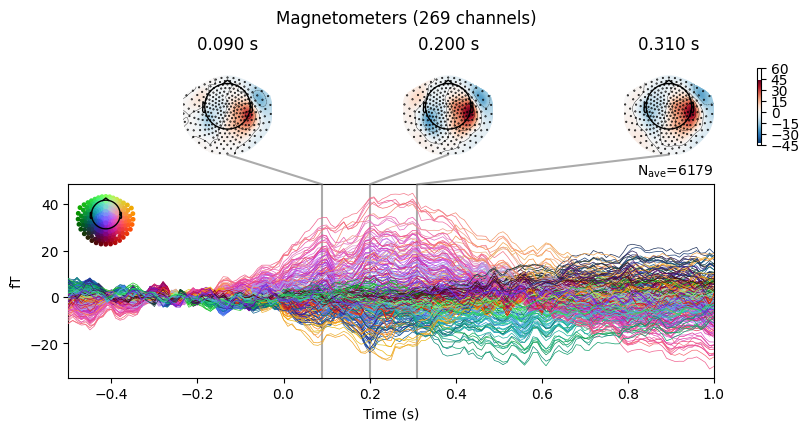

In [15]:
epochs.average().plot_joint()
plt.show()

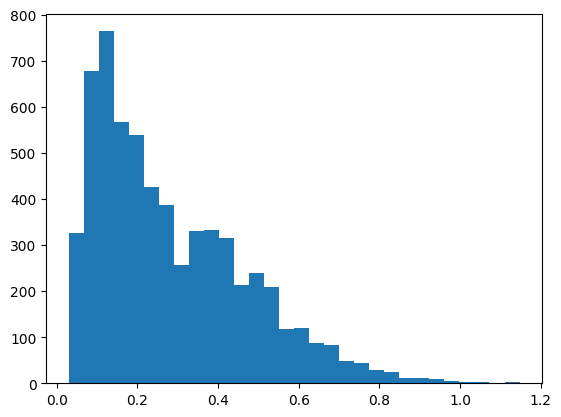

In [16]:
plt.hist(epochs.metadata['duration'].values, bins=30)
plt.show()

No projector specified for this dataset. Please consider the method self.add_proj.


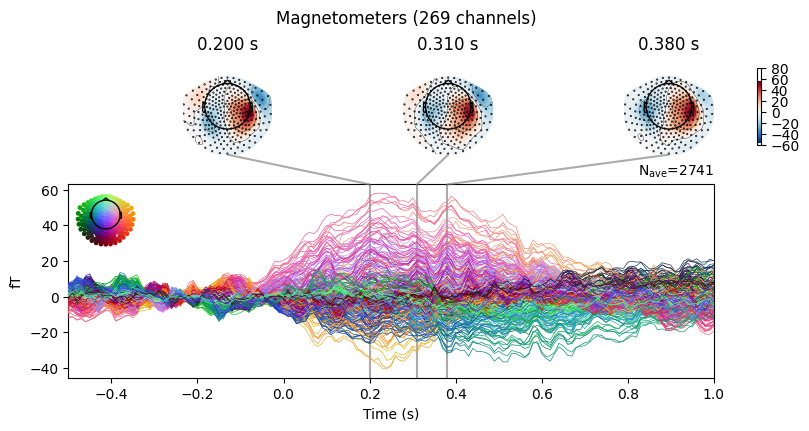

No projector specified for this dataset. Please consider the method self.add_proj.


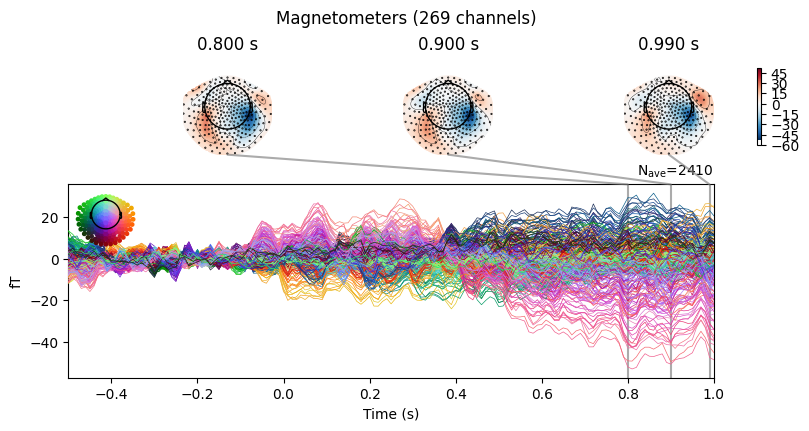

In [17]:
epochs_short = epochs["duration < 0.2"]
epochs_short.average().plot_joint()
plt.show()
# plot average response to long words
epochs_long = epochs["duration > 0.3"]
epochs_long.average().plot_joint()
plt.show()

In [18]:
import torch
from transformers import GPT2Tokenizer, GPT2Model


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import warnings
warnings.filterwarnings("ignore", message="`resume_download` is deprecated", category=FutureWarning)


In [20]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Load pre-trained model
model = GPT2Model.from_pretrained('gpt2', output_hidden_states=True)
model.eval()


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

## Cosine Similiarity for GPT-2 Layers

In [21]:
# SENTENCE 1

input_text1 = "With hardly a word spoken, but with a kindly eye, he waved me to an armchair, threw across his case of cigars"
input_ids1 = tokenizer.encode(input_text1, return_tensors='pt')  # Add the batch dimension

# Predict hidden states features for each layer
with torch.no_grad():
    outputs = model(input_ids1)
    hidden_states1 = outputs.hidden_states  # Output has shape [num_layers, batch_size, sequence_length, hidden_size]

# Convert hidden states to numpy
# Each item in hidden_states is a tensor for a layer, so we need to convert each and stack them
num_layers = len(hidden_states1)
sequence_length = hidden_states1[0].size(1)
hidden_size = hidden_states1[0].size(2)

# Prepare an array to hold the hidden states for all layers
all_hidden_states1 = np.zeros((num_layers, sequence_length, hidden_size))

# Collect hidden states from each layer
for i in range(num_layers):
    layer_hidden_states = hidden_states1[i].squeeze(0).cpu().numpy()  
    all_hidden_states1[i] = layer_hidden_states


# SENTENCE 2

input_text2 = "With hardly a word spoken, but with a kindly eye, he waved me to an armchair, threw across his case of flowers"
input_ids2 = tokenizer.encode(input_text2, return_tensors='pt')  

# Predict hidden states features for each layer
with torch.no_grad():
    outputs = model(input_ids2)
    hidden_states2 = outputs.hidden_states  # Output has shape [num_layers, batch_size, sequence_length, hidden_size]

# Each item in hidden_states is a tensor for a layer, so we need to convert each and stack them
num_layers = len(hidden_states2)
sequence_length = hidden_states2[0].size(1)
hidden_size = hidden_states2[0].size(2)

# Prepare an array to hold the hidden states for all layers
all_hidden_states2 = np.zeros((num_layers, sequence_length, hidden_size))

# Collect hidden states from each layer
for i in range(num_layers):
    layer_hidden_states = hidden_states2[i].squeeze(0).cpu().numpy()  
    all_hidden_states2[i] = layer_hidden_states

all_hidden_states2.shape

# 13 layers, 6 tokens, 768 artificial neurons

(13, 26, 768)

In [22]:
# loop through each layer and compute the similarity of just the last word of the sentences 
from sklearn.metrics.pairwise import cosine_similarity

for i in range(num_layers):
    cs = cosine_similarity([all_hidden_states1[i, -1, :]], [all_hidden_states2[i, -1, :]])
    print(f"Layer {i}, Cosine similarity:", cs)

Layer 0, Cosine similarity: [[0.67460221]]
Layer 1, Cosine similarity: [[0.70322824]]
Layer 2, Cosine similarity: [[0.72079013]]
Layer 3, Cosine similarity: [[0.76490635]]
Layer 4, Cosine similarity: [[0.75086153]]
Layer 5, Cosine similarity: [[0.75364967]]
Layer 6, Cosine similarity: [[0.75551403]]
Layer 7, Cosine similarity: [[0.79172942]]
Layer 8, Cosine similarity: [[0.82703754]]
Layer 9, Cosine similarity: [[0.85187984]]
Layer 10, Cosine similarity: [[0.87202808]]
Layer 11, Cosine similarity: [[0.91918322]]
Layer 12, Cosine similarity: [[0.9976983]]


In [23]:
# SENTENCE 1

input_text1 = "I went to the park and saw a dog"
input_ids1 = tokenizer.encode(input_text1, return_tensors='pt')  # Add the batch dimension

# Predict hidden states features for each layer
with torch.no_grad():
    outputs = model(input_ids1)
    hidden_states1 = outputs.hidden_states  # Output has shape [num_layers, batch_size, sequence_length, hidden_size]

# Convert hidden states to numpy
# Each item in hidden_states is a tensor for a layer, so we need to convert each and stack them
num_layers = len(hidden_states1)
sequence_length = hidden_states1[0].size(1)
hidden_size = hidden_states1[0].size(2)

# Prepare an array to hold the hidden states for all layers
all_hidden_states1 = np.zeros((num_layers, sequence_length, hidden_size))

# Collect hidden states from each layer
for i in range(num_layers):
    layer_hidden_states = hidden_states1[i].squeeze(0).cpu().numpy()  
    all_hidden_states1[i] = layer_hidden_states


# SENTENCE 2

input_text2 = "I went to the park and saw a truck"
input_ids2 = tokenizer.encode(input_text2, return_tensors='pt')  

# Predict hidden states features for each layer
with torch.no_grad():
    outputs = model(input_ids2)
    hidden_states2 = outputs.hidden_states  # Output has shape [num_layers, batch_size, sequence_length, hidden_size]

# Each item in hidden_states is a tensor for a layer, so we need to convert each and stack them
num_layers = len(hidden_states2)
sequence_length = hidden_states2[0].size(1)
hidden_size = hidden_states2[0].size(2)

# Prepare an array to hold the hidden states for all layers
all_hidden_states2 = np.zeros((num_layers, sequence_length, hidden_size))

# Collect hidden states from each layer
for i in range(num_layers):
    layer_hidden_states = hidden_states2[i].squeeze(0).cpu().numpy()  
    all_hidden_states2[i] = layer_hidden_states

all_hidden_states2.shape

# 13 layers, 6 tokens, 768 artificial neurons

(13, 9, 768)

In [24]:
# loop through each layer and compute the similarity of just the last word of the sentences 
from sklearn.metrics.pairwise import cosine_similarity

for i in range(num_layers):
    cs = cosine_similarity([all_hidden_states1[i, -1, :]], [all_hidden_states2[i, -1, :]])
    print(f"Layer {i}, Cosine similarity:", cs)

Layer 0, Cosine similarity: [[0.73130996]]
Layer 1, Cosine similarity: [[0.75714937]]
Layer 2, Cosine similarity: [[0.70439824]]
Layer 3, Cosine similarity: [[0.73608998]]
Layer 4, Cosine similarity: [[0.72889692]]
Layer 5, Cosine similarity: [[0.7349665]]
Layer 6, Cosine similarity: [[0.7374389]]
Layer 7, Cosine similarity: [[0.76107221]]
Layer 8, Cosine similarity: [[0.78702904]]
Layer 9, Cosine similarity: [[0.81747001]]
Layer 10, Cosine similarity: [[0.8272673]]
Layer 11, Cosine similarity: [[0.88113672]]
Layer 12, Cosine similarity: [[0.99637572]]


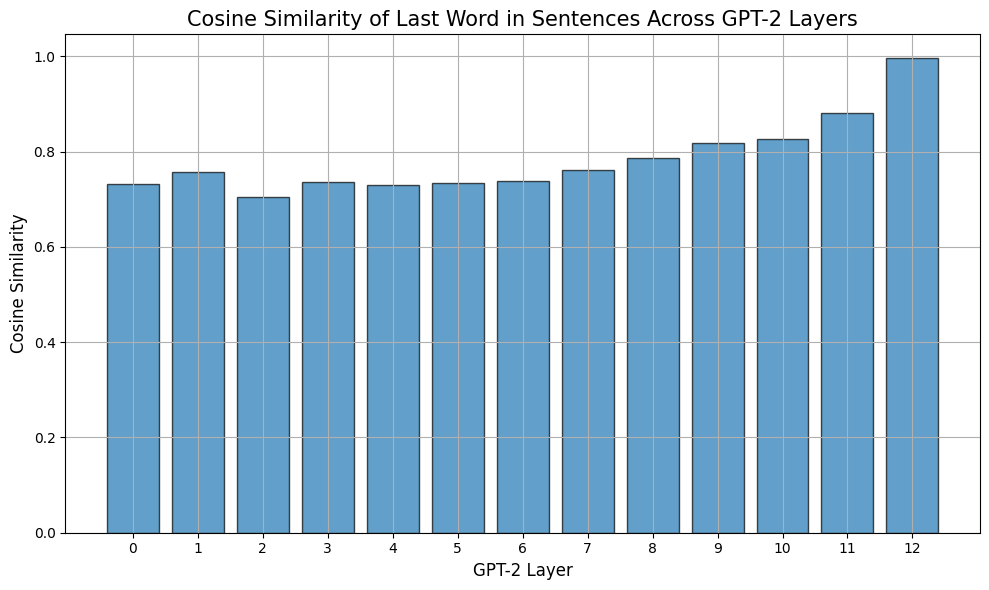

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Given cosine similarity values
cosine_similarities = [
    0.73130996, 0.75714937, 0.70439824, 0.73608998,
    0.72889692, 0.7349665, 0.7374389, 0.76107221,
    0.78702904, 0.81747001, 0.8272673, 0.88113672,
    0.99637572
]

num_layers = len(cosine_similarities)

# Plotting cosine similarity values as a bar chart
plt.figure(figsize=(10, 6))

# Define professional colors
bar_color = '#1f77b4'  # A professional blue color

plt.bar(range(num_layers), cosine_similarities, color=bar_color, edgecolor='black', alpha=0.7)

# Enhancing the plot
plt.title('Cosine Similarity of Last Word in Sentences Across GPT-2 Layers', fontsize=15)
plt.xlabel('GPT-2 Layer', fontsize=12)
plt.ylabel('Cosine Similarity', fontsize=12)
plt.xticks(range(num_layers), fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.tight_layout()
plt.show()


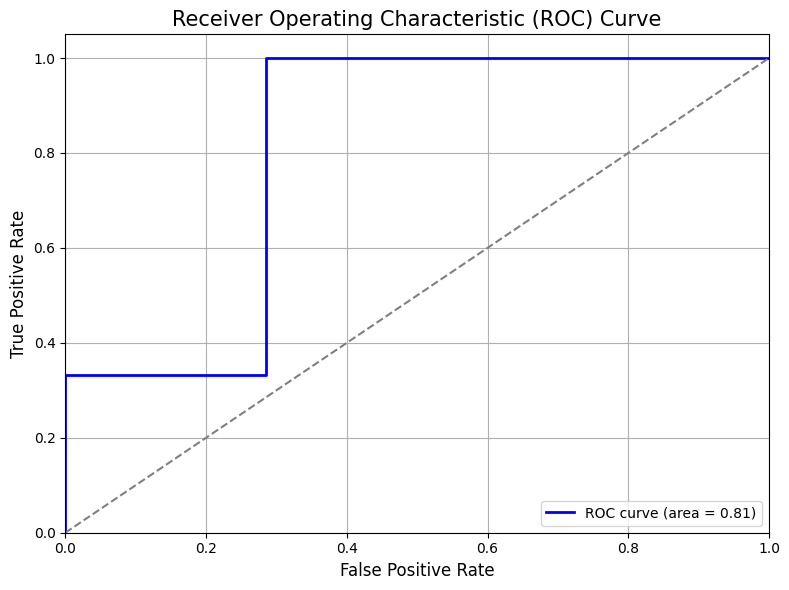

In [26]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming cosine_similarities is defined
# Generate example binary labels
labels = np.random.randint(2, size=len(cosine_similarities))

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(labels, cosine_similarities)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
neural_vec = df_crop["onset"].values
neural_vec

array([  38.86364336,   38.99334858,   39.67180663, ..., 3475.16651883,
       3475.28624672, 3475.38601996])

In [28]:
file_path = os.path.join(root_dir, 'stimuli', '01_1.txt')

with open(file_path, 'r') as file:
    content = file.read()

content_stripped = content.strip()
words = content_stripped.split()
text_list = ' '.join(words)

print(text_list)


THE ADVENTURES OF SHERLOCK HOLMES. A SCANDAL IN BOHEMIA. To Sherlock Holmes she is always THE woman. I have seldom heard him mention her under any other name. In his eyes she eclipses and predominates the whole of her sex. It was not that he felt any emotion akin to love for Irene Adler. All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. He was, I take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position. He never spoke of the softer passions, save with a gibe and a sneer. They were admirable things for the observer--excellent for drawing the veil from men's motives and actions. But for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results. Grit in a sensitive instrument, or a crack in one of his own high-pow

In [29]:

text_vec = df_crop["value"].values
text_list = (' ').join(text_vec.tolist())


In [30]:
df_crop

,onset,duration,sample,type,value
3,38.863643,0.129705,4.663737e+04,word_onset_01,THE
6,38.993349,0.678458,4.679302e+04,word_onset_01,ADVENTURES
15,39.671807,0.089796,4.760717e+04,word_onset_01,OF
18,39.761603,0.488889,4.771492e+04,word_onset_01,SHERLOCK
24,40.250491,0.698413,4.830159e+04,word_onset_01,HOLMES
...,...,...,...,...,...
29761,3474.697585,0.149660,4.169638e+06,word_onset_05,MY
29764,3474.847244,0.319274,4.169818e+06,word_onset_05,ORDERS
29770,3475.166519,0.119728,4.170201e+06,word_onset_05,TO
29773,3475.286247,0.099773,4.170344e+06,word_onset_05,THE


In [31]:
!install spacy

usage: install [-bCcpSsv] [-B suffix] [-f flags] [-g group] [-m mode]
               [-o owner] file1 file2
       install [-bCcpSsv] [-B suffix] [-f flags] [-g group] [-m mode]
               [-o owner] file1 ... fileN directory
       install -d [-v] [-g group] [-m mode] [-o owner] directory ...


## Tokenization for Word Embeddings

In [32]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

doc = nlp(text_list)

tokenized_words = [token.text for token in doc]


In [33]:
for wi, w in enumerate(df_crop['value'].values.tolist()):
    t = tokenized_words[wi]
    print(wi, t, w)
    if t != w:
        0/0

0 THE THE
1 ADVENTURES ADVENTURES
2 OF OF
3 SHERLOCK SHERLOCK
4 HOLMES HOLMES
5 A A
6 SCANDAL SCANDAL
7 IN IN
8 BOHEMIA BOHEMIA
9 TO TO
10 SHERLOCK SHERLOCK
11 HOLMES HOLMES
12 SHE SHE
13 IS IS
14 ALWAYS ALWAYS
15 THE THE
16 WOMAN WOMAN
17 I I
18 HAVE HAVE
19 SELDOM SELDOM
20 HEARD HEARD
21 HIM HIM
22 MENTION MENTION
23 HER HER
24 UNDER UNDER
25 ANY ANY
26 OTHER OTHER
27 NAME NAME
28 IN IN
29 HIS HIS
30 EYES EYES
31 SHE SHE
32 ECLIPSES ECLIPSES
33 AND AND
34 PREDOMINATES PREDOMINATES
35 THE THE
36 WHOLE WHOLE
37 OF OF
38 HER HER
39 SEX SEX
40 IT IT
41 WAS WAS
42 NOT NOT
43 THAT THAT
44 HE HE
45 FELT FELT
46 ANY ANY
47 EMOTION EMOTION
48 AKIN AKIN
49 TO TO
50 LOVE LOVE
51 FOR FOR
52 IRENE IRENE
53 ADLER ADLER
54 ALL ALL
55 EMOTIONS EMOTIONS
56 AND AND
57 THAT THAT
58 ONE ONE
59 PARTICULARLY PARTICULARLY
60 WERE WERE
61 ABHORRENT ABHORRENT
62 TO TO
63 HIS HIS
64 COLD COLD
65 PRECISE PRECISE
66 BUT BUT
67 ADMIRABLY ADMIRABLY
68 BALANCED BALANCED
69 MIND MIND
70 HE HE
71 WAS WAS
72 I I
73 

ZeroDivisionError: division by zero

In [ ]:
token_idx = np.logical_and([tk != "'" for tk in tokenized_words], [tk != "'S" for tk in tokenized_words])

In [ ]:
plt.plot(token_idx)

In [34]:
tokenized_words[120:140]

['OBSERVER',
 'EXCELLENT',
 'FOR',
 'DRAWING',
 'THE',
 'VEIL',
 'FROM',
 'MEN',
 "'S",
 'MOTIVES',
 'AND',
 'ACTIONS',
 'BUT',
 'FOR',
 'THE',
 'TRAINED',
 'REASONER',
 'TO',
 'ADMIT',
 'SUCH']

In [35]:
len(tokenized_words)

6193

In [36]:
df_crop[120:140]

,onset,duration,sample,type,value
598,90.226909,0.448980,108273.290405,word_onset_01,OBSERVER
607,91.404233,0.558730,109686.079521,word_onset_01,EXCELLENT
616,91.962963,0.119728,110356.555711,word_onset_01,FOR
619,92.082691,0.399093,110500.229181,word_onset_01,DRAWING
625,92.481784,0.059864,110979.140745,word_onset_01,THE
628,92.541648,0.349206,111050.977480,word_onset_01,VEIL
632,92.890854,0.219501,111470.025099,word_onset_01,FROM
636,93.110355,0.249433,111733.426460,word_onset_01,MEN'S
641,93.359788,0.558730,112032.746188,word_onset_01,MOTIVES
648,93.918519,0.129705,112703.222378,word_onset_01,AND


In [37]:
tokenized_words = [token.text for token in doc]
print(len(tokenized_words))

token_idx = np.logical_and([tk != "'" for tk in tokenized_words], [tk != "'S" for tk in tokenized_words])


6193


In [38]:
# CODE 1: EMBEDDING FOR EVERY WORD

# get what the tokens would be by default 
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")
doc = nlp(text_list)
tokenized_words = [token.text for token in doc]
token_idx = np.logical_and([tk != "'" for tk in tokenized_words], [tk != "'S" for tk in tokenized_words])

tokenized_chunks = []

for i in range(0, len(df_crop["value"].values), 50):
    text_vec = df_crop["value"].values[i:i+50]
    chunk_text = (' ').join(text_vec.tolist())
    
    # Tokenize the chunk using spaCy
    doc = nlp(chunk_text)
    input_ids = tokenizer.encode([token.text for token in doc], return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states1 = outputs.hidden_states  
    
    num_layers = len(hidden_states1)
    sequence_length = hidden_states1[0].size(1)
    hidden_size = hidden_states1[0].size(2)
    
    all_hidden_states1 = np.zeros((num_layers, sequence_length, hidden_size))
    
    for j in range(num_layers):
        #print(j)
        layer_hidden_states = hidden_states1[j].squeeze(0).cpu().numpy()  
        all_hidden_states1[j] = layer_hidden_states
    tokenized_chunks.append(all_hidden_states1)

tokenized_chunks = np.concatenate(tokenized_chunks, axis=1)

# remove the apostrophie tokens
tokenized_chunks = tokenized_chunks[:, token_idx, :]


In [39]:
tokenized_chunks.shape

(13, 6179, 768)

In [40]:
data_array = epochs.get_data()
data_array.shape

/var/folders/cx/4qfxt6g560d36cxwt6f_ypdr0000gn/T/ipykernel_69363/1395270772.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_array = epochs.get_data()


(6179, 269, 151)

# Regression Models

In [42]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import pickle

# data_array = epochs.get_data()  # shape: (words, channels, time points)
# word_embeddings = ...  # shape: (words, embedding_dimensions)

# Check dimensions
words, channels, time_points = data_array.shape
embedding_dimensions = tokenized_chunks.shape[1]
word_embeddings = tokenized_chunks[7, :, :] 

word_embeddings.shape

(6179, 768)

### Ridge Regression Model

In [62]:
# separate sessions at time blocks
# save file within the for loop
# print

best_channels = [4, 5, 4, 27, 20, 10, 9, 5, 2, 22]

kf = KFold(n_splits=10, shuffle=True, random_state=42)
save_interval = 10  # Save progress every 10 iterations
save_path = 'random_forest_results2.pkl'
results = []

# Load previous results if available
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        saved_data = pickle.load(f)
        results = saved_data.get('results', [])
        start_ch = saved_data.get('last_channel', 0)
        start_tp = saved_data.get('last_time_point', 0)
else:
    start_ch = 0
    start_tp = 0

for ch in best_channels[start_ch:]:
    for tp in range(start_tp, time_points):
        y = data_array[:, ch, tp]
        y_pred = np.zeros_like(y)
       
        for train_index, test_index in kf.split(word_embeddings):
            X_train, X_test = word_embeddings[train_index], word_embeddings[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = Ridge(alpha=10000)
            model.fit(X_train, y_train)

            y_pred[test_index] = model.predict(X_test)
        
        spearman_corr, _ = spearmanr(y, y_pred)
        results.append((ch, tp, spearman_corr))

        if len(results) % save_interval == 0:
            with open(save_path, 'wb') as f:
                pickle.dump({
                    'results': results,
                    'last_channel': ch,
                    'last_time_point': tp
                }, f)

results_array = np.array(results, dtype=[('channel', int), ('time_point', int), ('spearman_corr', float)])

best_result = max(results, key=lambda x: x[2])  # Maximize Spearman correlation
print(f"Best channel: {best_result[0]}, Best time point: {best_result[1]}, Spearman Correlation: {best_result[2]}")

# Final save
with open(save_path, 'wb') as f:
    pickle.dump({
        'results': results,
        'last_channel': ch,
        'last_time_point': tp
    }, f)


Best channel: 5, Best time point: 136, Spearman Correlation: 0.0748413014767854


In [39]:
saved_data

{'results': [(4, 0, -0.022811556633587943),
  (4, 1, -0.04446664072339798),
  (4, 2, -0.0531456619772574),
  (4, 3, -0.03125795190752968),
  (4, 4, -0.03868971821872259),
  (4, 5, -0.04644502610747135),
  (4, 6, -0.03620587962112137),
  (4, 7, -0.03184502852751656),
  (4, 8, -0.026737045019755278),
  (4, 9, -0.03406742328516234),
  (4, 10, -0.038859770795038905),
  (4, 11, -0.033813839423924436),
  (4, 12, -0.045507336689107135),
  (5, 0, -0.04306719620218115),
  (5, 1, -0.031137827109831477),
  (5, 2, -0.04337704064890818),
  (5, 3, -0.03584505540427027),
  (5, 4, -0.033426411498270595),
  (5, 5, -0.02960689459050908),
  (5, 6, -0.040628135057108855),
  (5, 7, -0.03378977891404496),
  (5, 8, -0.03453519947760502),
  (5, 9, -0.035392203223021425),
  (5, 10, -0.032389002175282705),
  (5, 11, -0.03278028396942096),
  (5, 12, -0.03741099092418475),
  (4, 0, -0.022811556633587943),
  (4, 1, -0.04446664072339798),
  (4, 2, -0.0531456619772574),
  (4, 3, -0.03125795190752968),
  (4, 4, -0.03

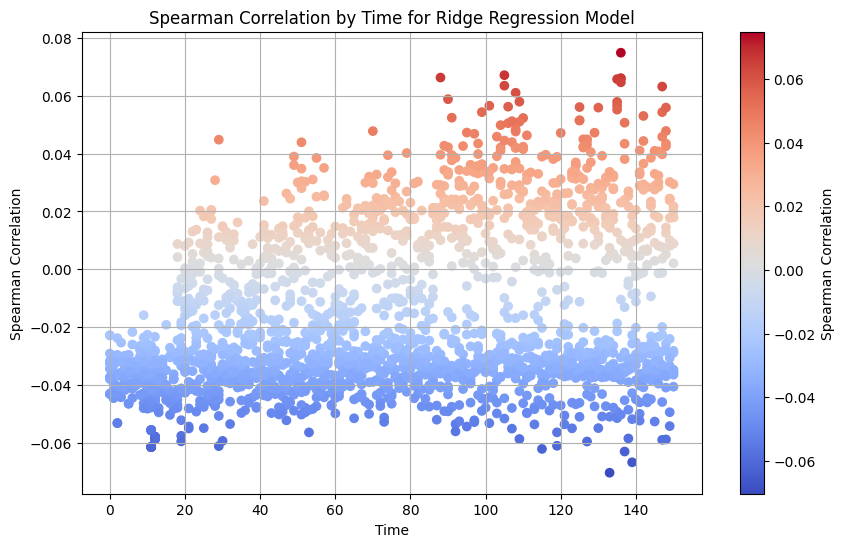

In [40]:
correlations = [result[2] for result in saved_data['results']]
timepoints = [result[1] for result in saved_data['results']]

# Create DataFrame (assuming Spearman correlation)
data = {'time': timepoints, 'correlation': correlations}
df = pd.DataFrame(data)


# Create scatter plot with color representing correlation
plt.figure(figsize=(10, 6))
plt.scatter(df['time'], df['correlation'], c=df['correlation'], cmap='coolwarm')  # Adjust colormap as needed
plt.colorbar(label='Spearman Correlation')  # Add colorbar for legend
plt.xlabel('Time')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by Time for Ridge Regression Model')
plt.grid(True)
plt.show()

In [42]:
# over the time period, you see that the spearman correlation move higher away from zero
# maybe suggests that longer time points work better for the model and word prediction

In [ ]:
y.shape

### Random Forest Regressor Model

In [60]:
# run random forest regressor with BEST CHANNELS (from ridge regression)
best_channels = [4, 5, 4, 27, 20, 10, 9, 5, 2, 22]

kf = KFold(n_splits=10, shuffle=True, random_state=42)
save_interval = 10  # Save progress every 10 iterations
save_path = 'random_forest_results2.pkl'
results = []

# Load previous results if available
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        saved_data = pickle.load(f)
        results = saved_data.get('results', [])
        start_ch = saved_data.get('last_channel', 0)
        start_tp = saved_data.get('last_time_point', 0)
else:
    start_ch = 0
    start_tp = 0

for ch in best_channels[start_ch:]:
    for tp in range(start_tp, time_points):
        y = data_array[:, ch, tp]
        y_pred = np.zeros_like(y)
       
        for train_index, test_index in kf.split(word_embeddings):
            X_train, X_test = word_embeddings[train_index], word_embeddings[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            
            y_pred[test_index] = model.predict(X_test)

        spearman_corr, _ = spearmanr(y, y_pred)
        results.append((ch, tp, spearman_corr))

        # Save results periodically
        if len(results) % save_interval == 0:
            with open(save_path, 'wb') as f:
                pickle.dump({
                    'results': results,
                    'last_channel': ch,
                    'last_time_point': tp
                }, f)

results_array = np.array(results, dtype=[('channel', int), ('time_point', int), ('metric', float)])

best_result = max(results, key=lambda x: x[2]) 
print(f"Best channel: {best_result[0]}, Best time point: {best_result[1]}, Spearman Correlation: {best_result[2]}")

# Final save
with open(save_path, 'wb') as f:
    pickle.dump({
        'results': results,
        'last_channel': best_channels.index(best_result[0]),
        'last_time_point': best_result[1]
    }, f)

print(saved_data)

Best channel: 5, Best time point: 136, Spearman Correlation: 0.0748413014767854
{'results': [(4, 0, -0.022811556633587943), (4, 1, -0.04446664072339798), (4, 2, -0.0531456619772574), (4, 3, -0.03125795190752968), (4, 4, -0.03868971821872259), (4, 5, -0.04644502610747135), (4, 6, -0.03620587962112137), (4, 7, -0.03184502852751656), (4, 8, -0.026737045019755278), (4, 9, -0.03406742328516234), (4, 10, -0.038859770795038905), (4, 11, -0.033813839423924436), (4, 12, -0.045507336689107135), (5, 0, -0.04306719620218115), (5, 1, -0.031137827109831477), (5, 2, -0.04337704064890818), (5, 3, -0.03584505540427027), (5, 4, -0.033426411498270595), (5, 5, -0.02960689459050908), (5, 6, -0.040628135057108855), (5, 7, -0.03378977891404496), (5, 8, -0.03453519947760502), (5, 9, -0.035392203223021425), (5, 10, -0.032389002175282705), (5, 11, -0.03278028396942096), (5, 12, -0.03741099092418475), (4, 0, -0.022811556633587943), (4, 1, -0.04446664072339798), (4, 2, -0.0531456619772574), (4, 3, -0.031257951907

In [55]:
saved_data

{'results': [(4, 0, -0.03337831514494674),
  (4, 1, -0.04690626408426319),
  (4, 2, -0.02689708133638751),
  (4, 3, -0.021164699588708303),
  (4, 4, -0.031926192013595416),
  (4, 5, -0.026866991046153258),
  (4, 6, -0.033805754303279006),
  (4, 7, -0.03339250869736748),
  (4, 8, -0.021062433341149444),
  (4, 9, -0.034541827489304074),
  (4, 10, -0.03537938649221787),
  (4, 11, -0.04566551433234166),
  (4, 12, -0.04234165683643917),
  (5, 0, -0.028196427751349753),
  (5, 1, -0.04650426049371359),
  (5, 2, -0.03695767803016248),
  (5, 3, -0.024451678770362705),
  (5, 4, -0.02840205167870852),
  (5, 5, -0.026403686226588056),
  (5, 6, -0.037716885264988856),
  (5, 7, -0.029989577716491314),
  (5, 8, -0.02267108606557624),
  (5, 9, -0.032103493965725816),
  (5, 10, -0.03422304068023816),
  (5, 11, -0.046562336401021205),
  (5, 12, -0.046379856644648505),
  (4, 0, -0.03337831514494674),
  (4, 1, -0.04690626408426319),
  (4, 2, -0.02689708133638751),
  (4, 3, -0.021164699588708303),
  (4, 4,

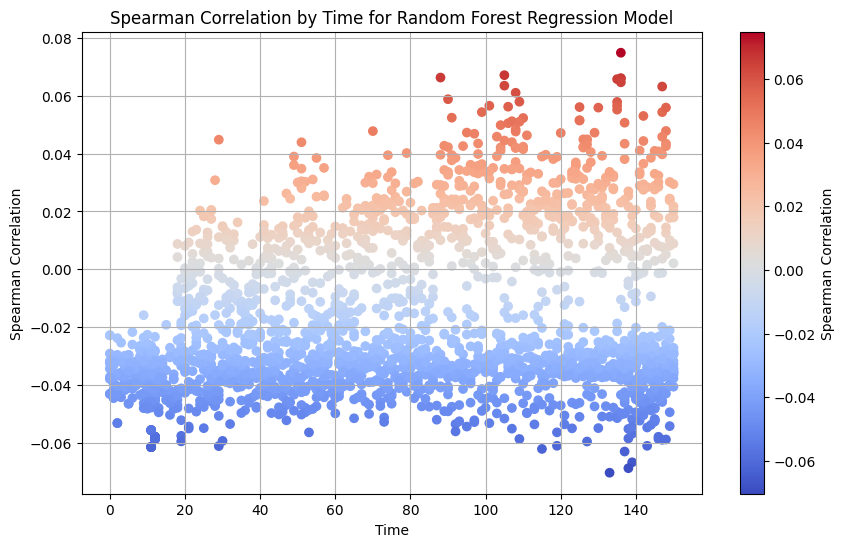

In [61]:
# plot RFG with BEST channels
correlations = [result[2] for result in saved_data['results']]
timepoints = [result[1] for result in saved_data['results']]

# Create DataFrame (assuming Spearman correlation)
data = {'time': timepoints, 'correlation': correlations}
df = pd.DataFrame(data)


# Create scatter plot with color representing correlation
plt.figure(figsize=(10, 6))
plt.scatter(df['time'], df['correlation'], c=df['correlation'], cmap='coolwarm')  # Adjust colormap as needed
plt.colorbar(label='Spearman Correlation')  # Add colorbar for legend
plt.xlabel('Time')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by Time for Random Forest Regression Model')
plt.grid(True)
plt.show()

In [ ]:
# spearman correlation is a nice performance metric (-1, 1)
# arbitrarily above or below chance, not gonna be exactly zero
# 

### XGBoost

In [47]:
# XGBoost with BEST channels (from ridge regression)
# run random forest regressor with BEST CHANNELS (from ridge regression)
best_channels = [4, 5, 4, 27, 20, 10, 9, 5, 2, 22]

kf = KFold(n_splits=10, shuffle=True, random_state=42)
save_interval = 10  # Save progress every 10 iterations
save_path = 'xgboost_regression_results2.pkl'
results = []

# Load previous results if available
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        saved_data = pickle.load(f)
        results = saved_data.get('results', [])
        start_ch = saved_data.get('last_channel', 0)
        start_tp = saved_data.get('last_time_point', 0)
else:
    start_ch = 0
    start_tp = 0

for ch in best_channels[start_ch:]:
    for tp in range(start_tp, time_points):
        y = data_array[:, ch, tp]
        y_pred = np.zeros_like(y)

        for train_index, test_index in kf.split(word_embeddings):
            X_train, X_test = word_embeddings[train_index], word_embeddings[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
            model.fit(X_train, y_train)
            
            y_pred[test_index] = model.predict(X_test)

        spearman_corr, _ = spearmanr(y, y_pred)
        results.append((ch, tp, spearman_corr))

        # Save results periodically
        if len(results) % save_interval == 0:
            with open(save_path, 'wb') as f:
                pickle.dump({
                    'results': results,
                    'last_channel': ch,
                    'last_time_point': tp
                }, f)

results_array = np.array(results, dtype=[('channel', int), ('time_point', int), ('metric', float)])

best_result = max(results, key=lambda x: x[2]) 
print(f"Best channel: {best_result[0]}, Best time point: {best_result[1]}, Spearman Correlation: {best_result[2]}")

# Final save
with open(save_path, 'wb') as f:
    pickle.dump({
        'results': results,
        'last_channel': best_channels.index(best_result[0]),
        'last_time_point': best_result[1]
    }, f)


Best channel: 22, Best time point: 124, Spearman Correlation: -0.014452740777204333


In [48]:
# saved_data WITH best channels
saved_data

{'results': [(4, 0, -0.03337831514494674),
  (4, 1, -0.04690626408426319),
  (4, 2, -0.02689708133638751),
  (4, 3, -0.021164699588708303),
  (4, 4, -0.031926192013595416),
  (4, 5, -0.026866991046153258),
  (4, 6, -0.033805754303279006),
  (4, 7, -0.03339250869736748),
  (4, 8, -0.021062433341149444),
  (4, 9, -0.034541827489304074),
  (4, 10, -0.03537938649221787),
  (4, 11, -0.04566551433234166),
  (4, 12, -0.04234165683643917),
  (5, 0, -0.028196427751349753),
  (5, 1, -0.04650426049371359),
  (5, 2, -0.03695767803016248),
  (5, 3, -0.024451678770362705),
  (5, 4, -0.02840205167870852),
  (5, 5, -0.026403686226588056),
  (5, 6, -0.037716885264988856),
  (5, 7, -0.029989577716491314),
  (5, 8, -0.02267108606557624),
  (5, 9, -0.032103493965725816),
  (5, 10, -0.03422304068023816),
  (5, 11, -0.046562336401021205),
  (5, 12, -0.046379856644648505),
  (4, 0, -0.03337831514494674),
  (4, 1, -0.04690626408426319),
  (4, 2, -0.02689708133638751),
  (4, 3, -0.021164699588708303),
  (4, 4,

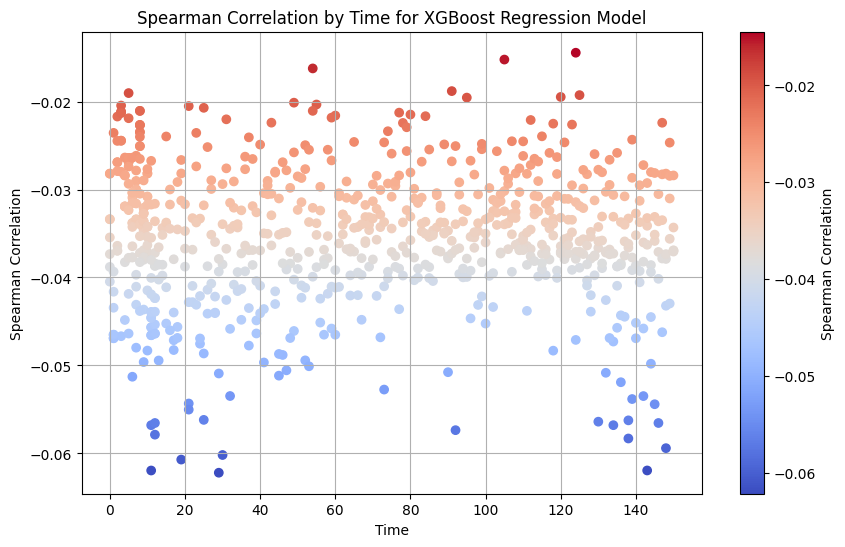

In [49]:
# plot XGB with BEST channels
correlations = [result[2] for result in saved_data['results']]
timepoints = [result[1] for result in saved_data['results']]

# Create DataFrame (assuming Spearman correlation)
data = {'time': timepoints, 'correlation': correlations}
df = pd.DataFrame(data)


# Create scatter plot with color representing correlation
plt.figure(figsize=(10, 6))
plt.scatter(df['time'], df['correlation'], c=df['correlation'], cmap='coolwarm')  # Adjust colormap as needed
plt.colorbar(label='Spearman Correlation')  # Add colorbar for legend
plt.xlabel('Time')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by Time for XGBoost Regression Model')
plt.grid(True)
plt.show()

In [ ]:
# old: 13 layers, 6 tokens, 768 artificial neurons
# new: 13 layers, 18 tokens, 768 artificial neurons
all_hidden_states1.shape

### Principal Component Regression (PCR) Model

In [43]:
import numpy as np
import os
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

best_channels = [4, 5, 27, 20, 10, 9, 5, 2, 22]

kf = KFold(n_splits=10, shuffle=True, random_state=42)
save_interval = 10  # Save progress every 10 iterations
save_path = 'pcr_regression_results.pkl'
results = []

# Load previous results if available
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        saved_data = pickle.load(f)
        results = saved_data.get('results', [])
        start_ch = saved_data.get('last_channel', 0)
        start_tp = saved_data.get('last_time_point', 0)
else:
    start_ch = 0
    start_tp = 0

# Number of principal components to use
n_components = 10

for ch_index in range(start_ch, len(best_channels)):
    ch = best_channels[ch_index]
    for tp in range(start_tp, time_points):
        y = data_array[:, ch, tp]
        y_pred = np.zeros_like(y)

        for train_index, test_index in kf.split(word_embeddings):
            X_train, X_test = word_embeddings[train_index], word_embeddings[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Apply PCA
            pca = PCA(n_components=n_components)
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)
            
            # Fit linear regression model
            model = LinearRegression()
            model.fit(X_train_pca, y_train)
            
            y_pred[test_index] = model.predict(X_test_pca)

        spearman_corr, _ = spearmanr(y, y_pred)
        results.append((ch, tp, spearman_corr))

        # Save results periodically
        if len(results) % save_interval == 0:
            with open(save_path, 'wb') as f:
                pickle.dump({
                    'results': results,
                    'last_channel': ch_index,
                    'last_time_point': tp
                }, f)

    # Reset start_tp for the next channel
    start_tp = 0

results_array = np.array(results, dtype=[('channel', int), ('time_point', int), ('metric', float)])

best_result = max(results, key=lambda x: x[2]) 
print(f"Best channel: {best_result[0]}, Best time point: {best_result[1]}, Spearman Correlation: {best_result[2]}")

# Final save
with open(save_path, 'wb') as f:
    pickle.dump({
        'results': results,
        'last_channel': best_channels.index(best_result[0]),
        'last_time_point': best_result[1]
    }, f)

print(saved_data)

Best channel: 2, Best time point: 12, Spearman Correlation: 0.33086108610861087
{'results': [(4, 0, -0.2764956495649565), (4, 1, -0.08243624362436243), (4, 2, -0.13759375937593757), (4, 3, -0.23648364836483649), (4, 4, -0.007968796879687967), (4, 5, -0.21576957695769575), (4, 6, -0.13478547854785478), (4, 7, -0.046156615661566154), (4, 8, -0.05453345334533453), (4, 9, -0.09790579057905789), (4, 10, 0.07096309630963096), (4, 11, -0.026546654665466546), (4, 12, -0.001836183618361836), (4, 13, -0.15536753675367534), (4, 14, 0.07763576357635764), (4, 15, 0.08292829282928293), (4, 16, -0.19408340834083404), (4, 17, -0.06053405340534053), (4, 18, -0.20772877287728772), (4, 19, -0.031755175517551755), (4, 20, -0.08709270927092709), (4, 21, 0.08258025802580256), (4, 22, 0.1198199819981998), (4, 23, -0.34159015901590156), (4, 24, 0.03725172517251725), (4, 25, -0.24349234923492347), (4, 26, -0.16247224722472245), (4, 27, -0.13084908490849081), (4, 28, -0.05368136813681367), (4, 29, -0.1415421542

In [64]:
saved_data = {'results': [(4, 0, -0.2764956495649565), (4, 1, -0.08243624362436243), (4, 2, -0.13759375937593757), (4, 3, -0.23648364836483649), (4, 4, -0.007968796879687967), (4, 5, -0.21576957695769575), (4, 6, -0.13478547854785478), (4, 7, -0.046156615661566154), (4, 8, -0.05453345334533453), (4, 9, -0.09790579057905789), (4, 10, 0.07096309630963096), (4, 11, -0.026546654665466546), (4, 12, -0.001836183618361836), (4, 13, -0.15536753675367534), (4, 14, 0.07763576357635764), (4, 15, 0.08292829282928293), (4, 16, -0.19408340834083404), (4, 17, -0.06053405340534053), (4, 18, -0.20772877287728772), (4, 19, -0.031755175517551755), (4, 20, -0.08709270927092709), (4, 21, 0.08258025802580256), (4, 22, 0.1198199819981998), (4, 23, -0.34159015901590156), (4, 24, 0.03725172517251725), (4, 25, -0.24349234923492347), (4, 26, -0.16247224722472245), (4, 27, -0.13084908490849081), (4, 28, -0.05368136813681367), (4, 29, -0.14154215421542152), (4, 30, -0.29159315931593155), (4, 31, -0.036927692769276925), (4, 32, 0.051785178517851777), (4, 33, -0.2669426942694269), (4, 34, -0.26299429942994296), (4, 35, 0.043900390039003895), (4, 36, 0.08576057605760576), (4, 37, 0.07848784878487848), (4, 38, -0.07041104110411041), (4, 39, -0.09477347734773477), (4, 40, -0.15025502550255024), (4, 41, 0.05930993099309931), (4, 42, -0.01212121212121212), (4, 43, -0.27990399039903985), (4, 44, 0.042328232823282325), (4, 45, 0.031227122712271224), (4, 46, -0.006660666066606659), (4, 47, 0.03345934593459345), (4, 48, 0.004716471647164716), (4, 49, -0.10198619861986198), (5, 0, -0.13302130213021301), (5, 1, -0.16279627962796275), (5, 2, -0.26955895589558954), (5, 3, -0.23498349834983495), (5, 4, -8.4008400840084e-05), (5, 5, -0.2974377437743774), (5, 6, -0.03859585958595859), (5, 7, 0.036495649564956496), (5, 8, -0.13665766576657665), (5, 9, -0.15894389438943896), (5, 10, -0.18654665466546652), (5, 11, -0.07405940594059406), (5, 12, -0.014509450945094506), (5, 13, -0.2917011701170117), (5, 14, -0.16494449444944492), (5, 15, -0.08156015601560154), (5, 16, -0.05652565256525652), (5, 17, -0.041452145214521445), (5, 18, 0.12225622562256225), (5, 19, -0.24956495649564955), (5, 20, -0.19104710471047104), (5, 21, 0.014593459345934593), (5, 22, -0.1362136213621362), (5, 23, -0.17789378937893788), (5, 24, -0.11741974197419741), (5, 25, -0.12406840684068406), (5, 26, -0.08717671767176717), (5, 27, 0.03443144314431443), (5, 28, -0.3456585658565856), (5, 29, -0.02916291629162916), (5, 30, 0.114011401140114), (5, 31, -0.017677767776777677), (5, 32, -0.13845784578457845), (5, 33, 0.04111611161116111), (5, 34, -0.001788178817881788), (5, 35, -0.15949594959495947), (5, 36, 0.06237023702370237), (5, 37, -0.3455145514551455), (5, 38, -0.3175637563756375), (5, 39, -0.038115811581158114), (5, 40, 0.08685268526852684), (5, 41, 0.024338433843384338), (5, 42, -0.12225622562256225), (5, 43, -0.2546654665466546), (5, 44, -0.18505850585058506), (5, 45, -0.09836183618361836), (5, 46, -0.09675367536753675), (5, 47, -0.18699069906990695), (5, 48, 0.030651065106510646), (5, 49, -0.06149414941494149), (4, 0, -0.2764956495649565), (4, 1, -0.08243624362436243), (4, 2, -0.13759375937593757), (4, 3, -0.23648364836483649), (4, 4, -0.007968796879687967), (4, 5, -0.21576957695769575), (4, 6, -0.13478547854785478), (4, 7, -0.046156615661566154), (4, 8, -0.05453345334533453), (4, 9, -0.09790579057905789), (4, 10, 0.07096309630963096), (4, 11, -0.026546654665466546), (4, 12, -0.001836183618361836), (4, 13, -0.15536753675367534), (4, 14, 0.07763576357635764), (4, 15, 0.08292829282928293), (4, 16, -0.19408340834083404), (4, 17, -0.06053405340534053), (4, 18, -0.20772877287728772), (4, 19, -0.031755175517551755), (4, 20, -0.08709270927092709), (4, 21, 0.08258025802580256), (4, 22, 0.1198199819981998), (4, 23, -0.34159015901590156), (4, 24, 0.03725172517251725), (4, 25, -0.24349234923492347), (4, 26, -0.16247224722472245), (4, 27, -0.13084908490849081), (4, 28, -0.05368136813681367), (4, 29, -0.14154215421542152), (4, 30, -0.29159315931593155), (4, 31, -0.036927692769276925), (4, 32, 0.051785178517851777), (4, 33, -0.2669426942694269), (4, 34, -0.26299429942994296), (4, 35, 0.043900390039003895), (4, 36, 0.08576057605760576), (4, 37, 0.07848784878487848), (4, 38, -0.07041104110411041), (4, 39, -0.09477347734773477), (4, 40, -0.15025502550255024), (4, 41, 0.05930993099309931), (4, 42, -0.01212121212121212), (4, 43, -0.27990399039903985), (4, 44, 0.042328232823282325), (4, 45, 0.031227122712271224), (4, 46, -0.006660666066606659), (4, 47, 0.03345934593459345), (4, 48, 0.004716471647164716), (4, 49, -0.10198619861986198), (27, 0, -0.040072007200720065), (27, 1, -0.2041044104410441), (27, 2, -0.11066306630663066), (27, 3, -0.25569756975697566), (27, 4, -0.03311131113111311), (27, 5, -0.34831083108310823), (27, 6, -0.2543894389438944), (27, 7, -0.057521752175217516), (27, 8, -0.09654965496549654), (27, 9, -0.06573057305730572), (27, 10, 0.11512751275127513), (27, 11, -0.23008700870087007), (27, 12, 0.0020882088208820882), (27, 13, -0.13020102010201018), (27, 14, -0.30526252625262523), (27, 15, -0.17018901890189017), (27, 16, -0.019957995799579954), (27, 17, 0.032835283528352834), (27, 18, -0.12705670567056704), (27, 19, -0.20841284128412838), (27, 20, -0.21556555655565554), (27, 21, 0.04505250525052505), (27, 22, -0.12993699369936992), (27, 23, 0.002868286828682868), (27, 24, -0.21275727572757272), (27, 25, -0.13626162616261625), (27, 26, -0.23277527752775276), (27, 27, -0.19085508550855085), (27, 28, -0.1537473747374737), (27, 29, -0.07834383438343834), (27, 30, -0.03618361836183618), (27, 31, -0.06718271827182717), (27, 32, -0.15788778877887788), (27, 33, -0.18175817581758172), (27, 34, -0.07198319831983198), (27, 35, -0.003636363636363636), (27, 36, 0.05237323732373236), (27, 37, 0.028046804680468045), (27, 38, 0.020546054605460544), (27, 39, -0.0874047404740474), (27, 40, -0.07023102310231022), (27, 41, -0.15354335433543354), (27, 42, -0.056009600960096), (27, 43, 0.03155115511551155), (27, 44, 0.11975997599759974), (27, 45, -0.27109510951095106), (27, 46, -0.1851065106510651), (27, 47, -0.1744134413441344), (27, 48, 0.2099249924992499), (27, 49, -0.16049204920492044), (20, 0, 0.07722772277227721), (20, 1, -0.04322832283228322), (20, 2, 0.06793879387938793), (20, 3, -0.04166816681668166), (20, 4, 0.08482448244824482), (20, 5, 0.04775277527752775), (20, 6, -0.06681068106810681), (20, 7, -0.15194719471947193), (20, 8, -0.03974797479747975), (20, 9, 0.04206420642064206), (20, 10, 0.12495649564956493), (20, 11, 0.03877587758775877), (20, 12, -0.32499249924992496), (20, 13, -0.33671767176717665), (20, 14, -0.3548154815481548), (20, 15, -0.12676867686768675), (20, 16, -0.4526012601260126), (20, 17, -0.2348274827482748), (20, 18, 0.10225022502250222), (20, 19, -0.08679267926792678), (20, 20, -0.16075607560756075), (20, 21, 0.010513051305130512), (20, 22, -0.1874107410741074), (20, 23, -0.00030003000300029994), (20, 24, 0.04121212121212121), (20, 25, 0.09735373537353735), (20, 26, -0.3945034503450344), (20, 27, -0.02151815181518152), (20, 28, -0.3287488748874887), (20, 29, 0.08057605760576057), (20, 30, -0.0643144314431443), (20, 31, -0.10143414341434143), (20, 32, -0.10498649864986496), (20, 33, -0.09364536453645364), (20, 34, 0.09753375337533753), (20, 35, -0.27197119711971196), (20, 36, 0.154023402340234), (20, 37, 0.10955895589558953), (20, 38, -0.1235883588358836), (20, 39, -0.47444344434443436), (20, 40, 0.08112811281128111), (20, 41, -0.16939693969396938), (20, 42, -0.16441644164416439), (20, 43, 0.14438643864386436), (20, 44, -0.08108010801080108), (20, 45, -0.20417641764176414), (20, 46, -0.29611761176117607), (20, 47, 0.06274227422742273), (20, 48, -0.04927692769276927), (20, 49, 0.10738673867386739), (10, 0, 0.2064206420642064), (10, 1, -0.06676267626762676), (10, 2, 0.11707170717071708), (10, 3, -0.3204200420042004), (10, 4, 0.03446744674467447), (10, 5, -0.15264326432643263), (10, 6, 0.025742574257425738), (10, 7, -0.2197299729972997), (10, 8, -0.08744074407440743), (10, 9, -0.17280528052805277), (10, 10, -0.18124212421242122), (10, 11, -0.09146114611461145), (10, 12, 0.10771077107710769), (10, 13, -0.3372097209720972), (10, 14, -0.14043804380438044), (10, 15, -0.2955415541554155), (10, 16, -0.04788478847884788), (10, 17, -0.10534653465346533), (10, 18, -0.14327032703270326), (10, 19, -0.00696069606960696), (10, 20, -0.1604440444044404), (10, 21, 0.040864086408640865), (10, 22, -0.18219021902190216), (10, 23, 0.043984398439843975), (10, 24, -0.09909390939093908), (10, 25, -0.3865226522652264), (10, 26, -0.023726372637263727), (10, 27, 0.1855385538553855), (10, 28, 0.12142814281428142), (10, 29, -0.05748574857485748), (10, 30, -0.09144914491449145), (10, 31, 0.10217821782178219), (10, 32, -0.0363036303630363), (10, 33, 0.2695229522952295), (10, 34, -0.3844224422442244), (10, 35, -0.13299729972997298), (10, 36, -0.2269066906690669), (10, 37, -0.11638763876387638), (10, 38, 0.2222142214221422), (10, 39, -0.3495109510951095), (10, 40, -0.07578757875787578), (10, 41, -0.18226222622262225), (10, 42, 0.03806780678067806), (10, 43, -0.15517551755175518), (10, 44, -0.2136213621362136), (10, 45, 0.01164116411641164), (10, 46, -0.13723372337233722), (10, 47, 0.1383858385838584), (10, 48, -0.11475547554755473), (10, 49, 0.10255025502550254), (9, 0, -0.05842184218421841), (9, 1, -0.1701290129012901), (9, 2, -0.1074947494749475), (9, 3, -0.1837263726372637), (9, 4, 0.10605460546054604), (9, 5, -0.133009300930093), (9, 6, -0.13591359135913592), (9, 7, 0.061674167416741664), (9, 8, -0.08392439243924392), (9, 9, 0.0045364536453645354), (9, 10, -0.005772577257725771), (9, 11, -0.07019501950195017), (9, 12, -0.12454845484548453), (9, 13, -0.21266126612661265), (9, 14, 0.12392439243924391), (9, 15, -0.05429342934293429), (9, 16, -0.23449144914491446), (9, 17, -0.06408640864086408), (9, 18, -0.0528052805280528), (9, 19, 0.14253825382538252), (9, 20, -0.21938193819381938), (9, 21, -0.08712871287128712), (9, 22, 0.003504350435043504), (9, 23, -0.09021302130213021), (9, 24, 0.14582658265826579), (9, 25, -0.20566456645664563), (9, 26, -0.08265226522652264), (9, 27, -0.22750675067506748), (9, 28, 0.10677467746774677), (9, 29, 0.04445244524452445), (9, 30, -0.0038643864386438635), (9, 31, -0.09394539453945393), (9, 32, 0.014161416141614161), (9, 33, -0.22729072907290726), (9, 34, -0.12378037803780376), (9, 35, -0.2106570657065706), (9, 36, -0.07702370237023702), (9, 37, 0.026762676267626757), (9, 38, -0.28643264326432644), (9, 39, -0.296021602160216), (9, 40, -0.15507950795079506), (9, 41, -0.11055505550555055), (9, 42, 0.1908070807080708), (9, 43, -0.02856285628562856), (9, 44, 0.0123012301230123), (9, 45, -0.05336933693369337), (9, 46, 0.025478547854785476), (9, 47, 0.08806480648064806), (9, 48, -0.0533093309330933), (9, 49, 0.064014401440144), (5, 0, -0.13302130213021301), (5, 1, -0.16279627962796275), (5, 2, -0.26955895589558954), (5, 3, -0.23498349834983495), (5, 4, -8.4008400840084e-05), (5, 5, -0.2974377437743774), (5, 6, -0.03859585958595859), (5, 7, 0.036495649564956496), (5, 8, -0.13665766576657665), (5, 9, -0.15894389438943896), (5, 10, -0.18654665466546652), (5, 11, -0.07405940594059406), (5, 12, -0.014509450945094506), (5, 13, -0.2917011701170117), (5, 14, -0.16494449444944492), (5, 15, -0.08156015601560154), (5, 16, -0.05652565256525652), (5, 17, -0.041452145214521445), (5, 18, 0.12225622562256225), (5, 19, -0.24956495649564955), (5, 20, -0.19104710471047104), (5, 21, 0.014593459345934593), (5, 22, -0.1362136213621362), (5, 23, -0.17789378937893788), (5, 24, -0.11741974197419741), (5, 25, -0.12406840684068406), (5, 26, -0.08717671767176717), (5, 27, 0.03443144314431443), (5, 28, -0.3456585658565856), (5, 29, -0.02916291629162916), (5, 30, 0.114011401140114), (5, 31, -0.017677767776777677), (5, 32, -0.13845784578457845), (5, 33, 0.04111611161116111), (5, 34, -0.001788178817881788), (5, 35, -0.15949594959495947), (5, 36, 0.06237023702370237), (5, 37, -0.3455145514551455), (5, 38, -0.3175637563756375), (5, 39, -0.038115811581158114), (5, 40, 0.08685268526852684), (5, 41, 0.024338433843384338), (5, 42, -0.12225622562256225), (5, 43, -0.2546654665466546), (5, 44, -0.18505850585058506), (5, 45, -0.09836183618361836), (5, 46, -0.09675367536753675), (5, 47, -0.18699069906990695), (5, 48, 0.030651065106510646), (5, 49, -0.06149414941494149), (2, 0, -0.16080408040804078), (2, 1, -0.2246144614461446), (2, 2, -0.1007020702070207), (2, 3, 0.021698169816981694), (2, 4, 0.022490249024902487), (2, 5, 0.1695169516951695), (2, 6, -0.1489108910891089), (2, 7, -0.02678667866786678), (2, 8, -0.045076507650765076), (2, 9, -0.19170717071707166), (2, 10, -0.19233123312331232), (2, 11, -0.1382178217821782), (2, 12, 0.33086108610861087), (2, 13, 0.1179237923792379), (2, 14, 0.03289528952895289), (2, 15, 0.08717671767176717), (2, 16, -0.11638763876387638), (2, 17, -0.20144014401440144), (2, 18, 0.11993999399939993), (2, 19, -0.08165616561656165), (2, 20, -0.07861986198619861), (2, 21, -0.09681368136813681), (2, 22, -0.1986078607860786), (2, 23, -0.040936093609360936), (2, 24, -0.03691569156915691), (2, 25, -0.17233723372337229), (2, 26, -0.15861986198619862), (2, 27, -0.11253525352535253), (2, 28, 0.14623462346234622), (2, 29, -0.11830783078307829), (2, 30, -0.09174917491749174), (2, 31, -0.21064506450645062), (2, 32, -0.19437143714371435), (2, 33, -0.19618361836183618), (2, 34, -0.23181518151815178), (2, 35, -0.16614461446144613), (2, 36, -0.2987338733873387), (2, 37, -0.031071107110711066), (2, 38, -0.02052205220522052), (2, 39, -0.19492349234923487), (2, 40, -0.16487248724872486), (2, 41, -0.17848184818481846), (2, 42, -0.2932373237323732), (2, 43, -0.07925592559255926), (2, 44, -0.10393039303930393), (2, 45, -0.18145814581458145), (2, 46, -0.17597359735973594), (2, 47, -0.1351335133513351), (2, 48, 0.1452505250525052), (2, 49, -0.23027902790279026), (22, 0, -0.22706270627062702), (22, 1, 0.1152115211521152), (22, 2, -0.037539753975397536), (22, 3, 0.12499249924992496), (22, 4, -0.11763576357635763), (22, 5, 0.103018301830183), (22, 6, -0.2524692469246924), (22, 7, 0.29144914491449136), (22, 8, -0.27373537353735367), (22, 9, -0.2047524752475247), (22, 10, -0.18851485148514852), (22, 11, -0.2756315631563156), (22, 12, -0.007896789678967895), (22, 13, 0.0931173117311731), (22, 14, -0.29591359135913586), (22, 15, -0.20364836483648363), (22, 16, -0.14274227422742272), (22, 17, -0.06347434743474346), (22, 18, -0.10855085508550853), (22, 19, -0.3521632163216321), (22, 20, -0.2665586558655865), (22, 21, -0.14257425742574256), (22, 22, -0.12069606960696068), (22, 23, -0.18689468946894688), (22, 24, -0.002868286828682868), (22, 25, -0.07057905790579058), (22, 26, 0.03419141914191419), (22, 27, 0.12634863486348633), (22, 28, -0.10288628862886287), (22, 29, 0.09614161416141613), (22, 30, -0.07023102310231022), (22, 31, -0.332013201320132), (22, 32, -0.07968796879687967), (22, 33, -0.0581098109810981), (22, 34, -0.15440744074407436), (22, 35, -0.11746774677467746), (22, 36, 0.07213921392139212), (22, 37, -0.22261026102610257), (22, 38, 0.23150315031503146), (22, 39, 0.005448544854485448), (22, 40, 0.02292229222922292), (22, 41, -0.22387038703870382), (22, 42, -0.45952595259525947), (22, 43, -0.2049204920492049), (22, 44, -0.2656225622562256), (22, 45, 0.004044404440444044), (22, 46, -0.3738613861386138), (22, 47, -0.03741974197419742), (22, 48, 0.011353135313531352), (22, 49, 0.12044404440444044), (2, 12, 0.33086108610861087), (2, 13, 0.1179237923792379), (2, 14, 0.03289528952895289), (2, 15, 0.08717671767176717), (2, 16, -0.11638763876387638), (2, 17, -0.20144014401440144), (2, 18, 0.11993999399939993), (2, 19, -0.08165616561656165), (2, 20, -0.07861986198619861), (2, 21, -0.09681368136813681), (2, 22, -0.1986078607860786), (2, 23, -0.040936093609360936), (2, 24, -0.03691569156915691), (2, 25, -0.17233723372337229), (2, 26, -0.15861986198619862), (2, 27, -0.11253525352535253), (2, 28, 0.14623462346234622), (2, 29, -0.11830783078307829), (2, 30, -0.09174917491749174), (2, 31, -0.21064506450645062), (2, 32, -0.19437143714371435), (2, 33, -0.19618361836183618), (2, 34, -0.23181518151815178), (2, 35, -0.16614461446144613), (2, 36, -0.2987338733873387), (2, 37, -0.031071107110711066), (2, 38, -0.02052205220522052), (2, 39, -0.19492349234923487), (2, 40, -0.16487248724872486), (2, 41, -0.17848184818481846), (2, 42, -0.2932373237323732), (2, 43, -0.07925592559255926), (2, 44, -0.10393039303930393), (2, 45, -0.18145814581458145), (2, 46, -0.17597359735973594), (2, 47, -0.1351335133513351), (2, 48, 0.1452505250525052), (2, 49, -0.23027902790279026), (22, 0, -0.22706270627062702), (22, 1, 0.1152115211521152), (22, 2, -0.037539753975397536), (22, 3, 0.12499249924992496), (22, 4, -0.11763576357635763), (22, 5, 0.103018301830183), (22, 6, -0.2524692469246924), (22, 7, 0.29144914491449136), (22, 8, -0.27373537353735367), (22, 9, -0.2047524752475247), (22, 10, -0.18851485148514852), (22, 11, -0.2756315631563156), (22, 12, -0.007896789678967895), (22, 13, 0.0931173117311731), (22, 14, -0.29591359135913586), (22, 15, -0.20364836483648363), (22, 16, -0.14274227422742272), (22, 17, -0.06347434743474346), (22, 18, -0.10855085508550853), (22, 19, -0.3521632163216321), (22, 20, -0.2665586558655865), (22, 21, -0.14257425742574256), (22, 22, -0.12069606960696068), (22, 23, -0.18689468946894688), (22, 24, -0.002868286828682868), (22, 25, -0.07057905790579058), (22, 26, 0.03419141914191419), (22, 27, 0.12634863486348633), (22, 28, -0.10288628862886287), (22, 29, 0.09614161416141613), (22, 30, -0.07023102310231022), (22, 31, -0.332013201320132), (22, 32, -0.07968796879687967), (22, 33, -0.0581098109810981), (22, 34, -0.15440744074407436), (22, 35, -0.11746774677467746), (22, 36, 0.07213921392139212), (22, 37, -0.22261026102610257), (22, 38, 0.23150315031503146), (22, 39, 0.005448544854485448), (22, 40, 0.02292229222922292), (22, 41, -0.22387038703870382), (22, 42, -0.45952595259525947), (22, 43, -0.2049204920492049), (22, 44, -0.2656225622562256), (22, 45, 0.004044404440444044), (22, 46, -0.3738613861386138), (22, 47, -0.03741974197419742), (22, 48, 0.011353135313531352), (22, 49, 0.12044404440444044), (2, 12, 0.33086108610861087), (2, 13, 0.1179237923792379), (2, 14, 0.03289528952895289), (2, 15, 0.08717671767176717), (2, 16, -0.11638763876387638), (2, 17, -0.20144014401440144), (2, 18, 0.11993999399939993), (2, 19, -0.08165616561656165), (2, 20, -0.07861986198619861), (2, 21, -0.09681368136813681), (2, 22, -0.1986078607860786), (2, 23, -0.040936093609360936), (2, 24, -0.03691569156915691), (2, 25, -0.17233723372337229), (2, 26, -0.15861986198619862), (2, 27, -0.11253525352535253), (2, 28, 0.14623462346234622), (2, 29, -0.11830783078307829), (2, 30, -0.09174917491749174), (2, 31, -0.21064506450645062), (2, 32, -0.19437143714371435), (2, 33, -0.19618361836183618), (2, 34, -0.23181518151815178), (2, 35, -0.16614461446144613), (2, 36, -0.2987338733873387), (2, 37, -0.031071107110711066), (2, 38, -0.02052205220522052), (2, 39, -0.19492349234923487), (2, 40, -0.16487248724872486), (2, 41, -0.17848184818481846), (2, 42, -0.2932373237323732), (2, 43, -0.07925592559255926), (2, 44, -0.10393039303930393), (2, 45, -0.18145814581458145), (2, 46, -0.17597359735973594), (2, 47, -0.1351335133513351), (2, 48, 0.1452505250525052), (2, 49, -0.23027902790279026), (22, 0, -0.22706270627062702), (22, 1, 0.1152115211521152), (22, 2, -0.037539753975397536), (22, 3, 0.12499249924992496), (22, 4, -0.11763576357635763), (22, 5, 0.103018301830183), (22, 6, -0.2524692469246924), (22, 7, 0.29144914491449136), (22, 8, -0.27373537353735367), (22, 9, -0.2047524752475247), (22, 10, -0.18851485148514852), (22, 11, -0.2756315631563156), (22, 12, -0.007896789678967895), (22, 13, 0.0931173117311731), (22, 14, -0.29591359135913586), (22, 15, -0.20364836483648363), (22, 16, -0.14274227422742272), (22, 17, -0.06347434743474346), (22, 18, -0.10855085508550853), (22, 19, -0.3521632163216321), (22, 20, -0.2665586558655865), (22, 21, -0.14257425742574256), (22, 22, -0.12069606960696068), (22, 23, -0.18689468946894688), (22, 24, -0.002868286828682868), (22, 25, -0.07057905790579058), (22, 26, 0.03419141914191419), (22, 27, 0.12634863486348633), (22, 28, -0.10288628862886287), (22, 29, 0.09614161416141613), (22, 30, -0.07023102310231022), (22, 31, -0.332013201320132), (22, 32, -0.07968796879687967), (22, 33, -0.0581098109810981), (22, 34, -0.15440744074407436), (22, 35, -0.11746774677467746), (22, 36, 0.07213921392139212), (22, 37, -0.22261026102610257), (22, 38, 0.23150315031503146), (22, 39, 0.005448544854485448), (22, 40, 0.02292229222922292), (22, 41, -0.22387038703870382), (22, 42, -0.45952595259525947), (22, 43, -0.2049204920492049), (22, 44, -0.2656225622562256), (22, 45, 0.004044404440444044), (22, 46, -0.3738613861386138), (22, 47, -0.03741974197419742), (22, 48, 0.011353135313531352), (22, 49, 0.12044404440444044)], 'last_channel': 8, 'last_time_point': 12}

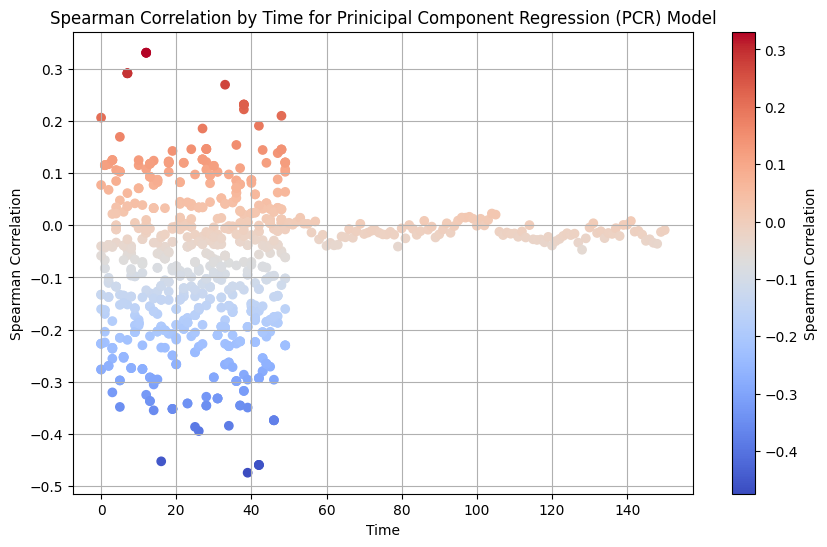

In [44]:
# plot PCA with BEST channels
correlations = [result[2] for result in saved_data['results']]
timepoints = [result[1] for result in saved_data['results']]

# Create DataFrame (assuming Spearman correlation)
data = {'time': timepoints, 'correlation': correlations}
df = pd.DataFrame(data)

# Create scatter plot with color representing correlation
plt.figure(figsize=(10, 6))
plt.scatter(df['time'], df['correlation'], c=df['correlation'], cmap='coolwarm')  # Adjust colormap as needed
plt.colorbar(label='Spearman Correlation')  # Add colorbar for legend
plt.xlabel('Time')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by Time for Prinicipal Component Regression (PCR) Model')
plt.grid(True)
plt.show()

In [69]:
from sklearn.linear_model import ElasticNet

best_channels = [4, 5, 4, 27, 20, 10, 9, 5, 2, 22]

kf = KFold(n_splits=10, shuffle=True, random_state=42)
save_interval = 10  # Save progress every 10 iterations
save_path = 'elastic_net_regression_results.pkl'
results = []

# Load previous results if available
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        saved_data = pickle.load(f)
        results = saved_data.get('results', [])
        start_ch = saved_data.get('last_channel', 0)
        start_tp = saved_data.get('last_time_point', 0)
else:
    start_ch = 0
    start_tp = 0

# ElasticNet parameters
alpha = 0.01
l1_ratio = 0.5

for ch_index in range(start_ch, len(best_channels)):
    ch = best_channels[ch_index]
    for tp in range(start_tp, time_points):
        y = data_array[:, ch, tp]
        y_pred = np.zeros_like(y)

        for train_index, test_index in kf.split(word_embeddings):
            X_train, X_test = word_embeddings[train_index], word_embeddings[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
            model.fit(X_train, y_train)
            
            y_pred[test_index] = model.predict(X_test)

        spearman_corr, _ = spearmanr(y, y_pred)
        results.append((ch, tp, spearman_corr))

        # Save results periodically
        if len(results) % save_interval == 0:
            with open(save_path, 'wb') as f:
                pickle.dump({
                    'results': results,
                    'last_channel': ch_index,
                    'last_time_point': tp
                }, f)

    # Reset start_tp for the next channel
    start_tp = 0

results_array = np.array(results, dtype=[('channel', int), ('time_point', int), ('metric', float)])

best_result = max(results, key=lambda x: x[2]) 
print(f"Best channel: {best_result[0]}, Best time point: {best_result[1]}, Spearman Correlation: {best_result[2]}")

# Final save
with open(save_path, 'wb') as f:
    pickle.dump({
        'results': results,
        'last_channel': best_channels.index(best_result[0]),
        'last_time_point': best_result[1]
    }, f)

print(saved_data)

Best channel: 27, Best time point: 34, Spearman Correlation: 0.4575697569756976
{'results': [(4, 0, -0.20896489648964897), (4, 1, 0.11492349234923491), (4, 2, 0.13485748574857484), (4, 3, 0.2484248424842484), (4, 4, -0.16324032403240324), (4, 5, 0.32729672967296725), (4, 6, 0.11115511551155113), (4, 7, 0.17849384938493845), (4, 8, 0.15807980798079804), (4, 9, -0.05143714371437143), (4, 10, 0.06237023702370237), (4, 11, 0.18762676267626763), (4, 12, -0.07698769876987699), (4, 13, -0.2048964896489649), (4, 14, 0.22294629462946294), (4, 15, 0.151995199519952), (4, 16, -0.2777797779777978), (4, 17, 0.17544554455445543), (4, 18, 0.06663066306630662), (4, 19, -0.09254125412541253), (4, 20, -0.02772277227722772), (4, 21, -0.11692769276927692), (4, 22, 0.3057665766576657), (4, 23, -0.26856285628562854), (4, 24, 0.21458145814581456), (4, 25, -0.3703930393039303), (4, 26, 0.020942094209420937), (4, 27, 0.09850585058505851), (4, 28, 0.22595859585958591), (4, 29, -0.23264326432643262), (4, 30, -0.

In [72]:
saved_data = {'results': [(4, 0, -0.20896489648964897), (4, 1, 0.11492349234923491), (4, 2, 0.13485748574857484), (4, 3, 0.2484248424842484), (4, 4, -0.16324032403240324), (4, 5, 0.32729672967296725), (4, 6, 0.11115511551155113), (4, 7, 0.17849384938493845), (4, 8, 0.15807980798079804), (4, 9, -0.05143714371437143), (4, 10, 0.06237023702370237), (4, 11, 0.18762676267626763), (4, 12, -0.07698769876987699), (4, 13, -0.2048964896489649), (4, 14, 0.22294629462946294), (4, 15, 0.151995199519952), (4, 16, -0.2777797779777978), (4, 17, 0.17544554455445543), (4, 18, 0.06663066306630662), (4, 19, -0.09254125412541253), (4, 20, -0.02772277227722772), (4, 21, -0.11692769276927692), (4, 22, 0.3057665766576657), (4, 23, -0.26856285628562854), (4, 24, 0.21458145814581456), (4, 25, -0.3703930393039303), (4, 26, 0.020942094209420937), (4, 27, 0.09850585058505851), (4, 28, 0.22595859585958591), (4, 29, -0.23264326432643262), (4, 30, -0.21777377737773773), (4, 31, -0.05269726972697269), (4, 32, -0.24040804080408035), (4, 33, -0.24782478247824777), (4, 34, -0.132013201320132), (4, 35, 0.41878187818781876), (4, 36, 0.035163516351635164), (4, 37, -0.1233003300330033), (4, 38, 0.08282028202820281), (4, 39, -0.137017701770177), (4, 40, 0.017353735373537352), (4, 41, 0.1765976597659766), (4, 42, 0.23698769876987696), (4, 43, -0.06391839183918391), (4, 44, -0.16762076207620757), (4, 45, 0.02053405340534053), (4, 46, -0.168016801680168), (4, 47, 0.01225322532253225), (4, 48, 0.06687068706870687), (4, 49, -0.20405640564056404), (5, 0, -0.11019501950195018), (5, 1, 0.2465406540654065), (5, 2, 0.08018001800180016), (5, 3, -0.2612421242124212), (5, 4, 0.20534053405340533), (5, 5, -0.11138313831383137), (5, 6, -0.175013501350135), (5, 7, 0.024218421842184215), (5, 8, -0.17263726372637261), (5, 9, -0.011929192919291929), (5, 10, -0.1761056105610561), (5, 11, 0.003372337233723372), (5, 12, 0.23905190519051903), (5, 13, 0.005712571257125713), (5, 14, 0.027506750675067502), (5, 15, -0.12097209720972095), (5, 16, -0.03798379837983798), (5, 17, -0.08529252925292528), (5, 18, 0.1061146114611461), (5, 19, -0.14774677467746775), (5, 20, -0.06228622862286228), (5, 21, 0.2859645964596459), (5, 22, 0.1074107410741074), (5, 23, 0.08553255325532552), (5, 24, -0.14073807380738074), (5, 25, -0.15985598559855985), (5, 26, 0.16675667566756672), (5, 27, -0.0058685868586858675), (5, 28, -0.20285628562856284), (5, 29, -0.18197419741974194), (5, 30, -0.14755475547554753), (5, 31, 0.36360036003600354), (5, 32, -0.17116111611161114), (5, 33, -0.08067206720672067), (5, 34, 0.1914071407140714), (5, 35, 0.11228322832283229), (5, 36, 0.21647764776477643), (5, 37, 0.28920492049204916), (5, 38, 0.04775277527752775), (5, 39, -0.13792979297929792), (5, 40, 0.0087008700870087), (5, 41, 0.03546354635463546), (5, 42, 0.12142814281428142), (5, 43, 0.029198919891989195), (5, 44, 0.14366636663666366), (5, 45, -0.0327032703270327), (5, 46, 0.03554755475547554), (5, 47, 0.014509450945094506), (5, 48, 0.29472547254725473), (5, 49, 0.06315031503150315), (4, 0, -0.20896489648964897), (4, 1, 0.11492349234923491), (4, 2, 0.13485748574857484), (4, 3, 0.2484248424842484), (4, 4, -0.16324032403240324), (4, 5, 0.32729672967296725), (4, 6, 0.11115511551155113), (4, 7, 0.17849384938493845), (4, 8, 0.15807980798079804), (4, 9, -0.05143714371437143), (4, 10, 0.06237023702370237), (4, 11, 0.18762676267626763), (4, 12, -0.07698769876987699), (4, 13, -0.2048964896489649), (4, 14, 0.22294629462946294), (4, 15, 0.151995199519952), (4, 16, -0.2777797779777978), (4, 17, 0.17544554455445543), (4, 18, 0.06663066306630662), (4, 19, -0.09254125412541253), (4, 20, -0.02772277227722772), (4, 21, -0.11692769276927692), (4, 22, 0.3057665766576657), (4, 23, -0.26856285628562854), (4, 24, 0.21458145814581456), (4, 25, -0.3703930393039303), (4, 26, 0.020942094209420937), (4, 27, 0.09850585058505851), (4, 28, 0.22595859585958591), (4, 29, -0.23264326432643262), (4, 30, -0.21777377737773773), (4, 31, -0.05269726972697269), (4, 32, -0.24040804080408035), (4, 33, -0.24782478247824777), (4, 34, -0.132013201320132), (4, 35, 0.41878187818781876), (4, 36, 0.035163516351635164), (4, 37, -0.1233003300330033), (4, 38, 0.08282028202820281), (4, 39, -0.137017701770177), (4, 40, 0.017353735373537352), (4, 41, 0.1765976597659766), (4, 42, 0.23698769876987696), (4, 43, -0.06391839183918391), (4, 44, -0.16762076207620757), (4, 45, 0.02053405340534053), (4, 46, -0.168016801680168), (4, 47, 0.01225322532253225), (4, 48, 0.06687068706870687), (4, 49, -0.20405640564056404), (27, 0, 0.06323432343234323), (27, 1, -0.043408340834083396), (27, 2, 0.002532253225322532), (27, 3, 0.1878307830783078), (27, 4, 0.1004260426042604), (27, 5, 0.1972157215721572), (27, 6, -0.17228922892289225), (27, 7, 0.09874587458745873), (27, 8, 0.08229222922292229), (27, 9, 0.05142514251425142), (27, 10, 0.07495949594959495), (27, 11, 0.12153615361536153), (27, 12, 0.20524452445244523), (27, 13, -0.006480648064806481), (27, 14, 0.12450045004500448), (27, 15, -0.39162316231623157), (27, 16, -0.1984158415841584), (27, 17, -0.057329732973297326), (27, 18, 0.04429642964296429), (27, 19, -0.16003600360036002), (27, 20, 0.26179417941794175), (27, 21, 0.05296129612961295), (27, 22, 0.10594659465946593), (27, 23, -0.21729372937293728), (27, 24, 0.05983798379837983), (27, 25, 0.023690369036903688), (27, 26, 0.1212001200120012), (27, 27, -0.13598559855985598), (27, 28, 0.14877887788778876), (27, 29, 0.10432643264326431), (27, 30, -0.00558055805580558), (27, 31, 0.04181218121812181), (27, 32, -0.058145814581458136), (27, 33, -0.004032403240324032), (27, 34, 0.4575697569756976), (27, 35, -0.047572757275727566), (27, 36, -0.15337533753375335), (27, 37, 0.1445184518451845), (27, 38, -0.23494749474947493), (27, 39, 0.2097329732973297), (27, 40, -0.14663066306630662), (27, 41, -0.0640984098409841), (27, 42, 0.041608160816081596), (27, 43, 0.04354035403540354), (27, 44, 0.15905190519051907), (27, 45, 0.03501950195019502), (27, 46, 0.04330033003300329), (27, 47, -0.017617761776177618), (27, 48, 0.3864146414641464), (27, 49, -0.2958175817581758), (20, 0, 0.23948394839483947), (20, 1, 0.07803180318031804), (20, 2, -0.17383738373837382), (20, 3, -0.3305010501050105), (20, 4, -0.04354035403540354), (20, 5, 0.07872787278727872), (20, 6, -0.06131413141314131), (20, 7, 0.03840384038403839), (20, 8, -0.002976297629762976), (20, 9, 0.18327032703270324), (20, 10, -0.04354035403540354), (20, 11, -0.09716171617161716), (20, 12, -0.18376237623762376), (20, 13, -0.1344374437443744), (20, 14, -0.15894389438943896), (20, 15, 0.033135313531353135), (20, 16, -0.2293189318931893), (20, 17, -0.08879687968796879), (20, 18, 0.05155715571557155), (20, 19, 0.05604560456045604), (20, 20, -0.1639363936393639), (20, 21, -0.005508550855085508), (20, 22, -0.24189618961896187), (20, 23, 0.2028322832283228), (20, 24, 0.07865586558655864), (20, 25, -0.09566156615661565), (20, 26, -0.227038703870387), (20, 27, -0.017905790579057907), (20, 28, -0.17896189618961894), (20, 29, -0.1796219621962196), (20, 30, 0.04163216321632163), (20, 31, 0.11027902790279026), (20, 32, -0.04682868286828682), (20, 33, -0.13346534653465345), (20, 34, -0.07228322832283227), (20, 35, 0.23330333033303327), (20, 36, 0.13616561656165613), (20, 37, 0.19925592559255925), (20, 38, 0.048124812481248114), (20, 39, 0.044020402040204014), (20, 40, -0.0531053105310531), (20, 41, -0.21045304530453043), (20, 42, 0.16529252925292526), (20, 43, 0.13216921692169215), (20, 44, -0.07209120912091209), (20, 45, -0.028310831083108307), (20, 46, -0.0673027302730273), (20, 47, -0.0846204620462046), (20, 48, 0.000168016801680168), (20, 49, 0.08367236723672367), (10, 0, 0.3541794179417941), (10, 1, 0.18935493549354934), (10, 2, 0.04204020402040203), (10, 3, -0.08704470447044703), (10, 4, 0.009456945694569457), (10, 5, 0.01789378937893789), (10, 6, 0.16152415241524148), (10, 7, 0.2503570357035703), (10, 8, 0.012049204920492046), (10, 9, 0.25756975697569756), (10, 10, 0.04399639963996399), (10, 11, -0.054281428142814274), (10, 12, 0.007236723672367236), (10, 13, -0.24296429642964296), (10, 14, -0.058613861386138603), (10, 15, -0.14059405940594058), (10, 16, 0.043000300030003), (10, 17, 0.04052805280528052), (10, 18, -0.0576057605760576), (10, 19, -0.03341134113411341), (10, 20, -0.07104710471047104), (10, 21, -0.20420042004200417), (10, 22, -0.04984098409840984), (10, 23, 0.1533273327332733), (10, 24, -0.09914191419141914), (10, 25, 0.16525652565256524), (10, 26, -0.14718271827182716), (10, 27, 0.2912331233123312), (10, 28, 0.16342034203420341), (10, 29, -0.09266126612661264), (10, 30, 0.27613561356135613), (10, 31, 0.015409540954095408), (10, 32, -0.12655265526552656), (10, 33, 0.10429042904290428), (10, 34, -0.24006000600060004), (10, 35, 0.001968196819681968), (10, 36, -0.05842184218421841), (10, 37, -0.3520192019201919), (10, 38, -0.05791779177917791), (10, 39, -0.12266426642664265), (10, 40, -0.03618361836183618), (10, 41, -0.03673567356735673), (10, 42, 0.040216021602160215), (10, 43, -0.07582358235823582), (10, 44, 0.057257725772577255), (10, 45, 0.12507650765076506), (10, 46, -0.09972997299729973), (10, 47, -0.10663066306630663), (10, 48, 0.01626162616261626), (10, 49, 0.15189918991899187), (9, 0, -0.10550255025502549), (9, 1, 0.06635463546354634), (9, 2, 0.18189018901890186), (9, 3, 0.03134713471347134), (9, 4, -0.13256525652565257), (9, 5, 0.024338433843384338), (9, 6, -0.222010201020102), (9, 7, -0.0428082808280828), (9, 8, -0.15395139513951395), (9, 9, -0.08877287728772876), (9, 10, 0.10127812781278125), (9, 11, 0.10984698469846983), (9, 12, -0.03359135913591359), (9, 13, -0.02317431743174317), (9, 14, 0.030843084308430843), (9, 15, -0.16170417041704166), (9, 16, -0.0013561356135613559), (9, 17, 0.023834383438343834), (9, 18, -0.0989138913891389), (9, 19, 0.05410141014101409), (9, 20, -0.04051605160516051), (9, 21, 0.04505250525052505), (9, 22, 0.30463846384638454), (9, 23, 0.28950495049504943), (9, 24, -0.12206420642064204), (9, 25, 0.10003000300030002), (9, 26, 0.04793279327932793), (9, 27, 0.26354635463546355), (9, 28, 0.025730573057305726), (9, 29, -0.13017701770177018), (9, 30, 0.1307170717071707), (9, 31, -0.2394359435943594), (9, 32, -0.23116711671167114), (9, 33, -0.2030963096309631), (9, 34, -0.28012001200120007), (9, 35, -0.056345634563456336), (9, 36, 0.19689168916891686), (9, 37, 0.16148814881488144), (9, 38, -0.0875967596759676), (9, 39, -0.08472847284728471), (9, 40, -0.16584458445844583), (9, 41, 0.3433423342334233), (9, 42, 0.06123012301230122), (9, 43, -0.12217221722172215), (9, 44, -0.05578157815781578), (9, 45, -0.044776477647764774), (9, 46, -0.20442844284428438), (9, 47, -0.12188418841884187), (9, 48, -0.3698049804980498), (9, 49, -0.17083708370837083), (5, 0, -0.11019501950195018), (5, 1, 0.2465406540654065), (5, 2, 0.08018001800180016), (5, 3, -0.2612421242124212), (5, 4, 0.20534053405340533), (5, 5, -0.11138313831383137), (5, 6, -0.175013501350135), (5, 7, 0.024218421842184215), (5, 8, -0.17263726372637261), (5, 9, -0.011929192919291929), (5, 10, -0.1761056105610561), (5, 11, 0.003372337233723372), (5, 12, 0.23905190519051903), (5, 13, 0.005712571257125713), (5, 14, 0.027506750675067502), (5, 15, -0.12097209720972095), (5, 16, -0.03798379837983798), (5, 17, -0.08529252925292528), (5, 18, 0.1061146114611461), (5, 19, -0.14774677467746775), (5, 20, -0.06228622862286228), (5, 21, 0.2859645964596459), (5, 22, 0.1074107410741074), (5, 23, 0.08553255325532552), (5, 24, -0.14073807380738074), (5, 25, -0.15985598559855985), (5, 26, 0.16675667566756672), (5, 27, -0.0058685868586858675), (5, 28, -0.20285628562856284), (5, 29, -0.18197419741974194), (5, 30, -0.14755475547554753), (5, 31, 0.36360036003600354), (5, 32, -0.17116111611161114), (5, 33, -0.08067206720672067), (5, 34, 0.1914071407140714), (5, 35, 0.11228322832283229), (5, 36, 0.21647764776477643), (5, 37, 0.28920492049204916), (5, 38, 0.04775277527752775), (5, 39, -0.13792979297929792), (5, 40, 0.0087008700870087), (5, 41, 0.03546354635463546), (5, 42, 0.12142814281428142), (5, 43, 0.029198919891989195), (5, 44, 0.14366636663666366), (5, 45, -0.0327032703270327), (5, 46, 0.03554755475547554), (5, 47, 0.014509450945094506), (5, 48, 0.29472547254725473), (5, 49, 0.06315031503150315), (2, 0, -0.3738013801380138), (2, 1, -0.16314431443144312), (2, 2, 0.011125112511251124), (2, 3, 0.06808280828082806), (2, 4, 0.13700570057005698), (2, 5, -0.10862286228622861), (2, 6, -0.10419441944194417), (2, 7, -0.24267626762676262), (2, 8, 0.0708190819081908), (2, 9, 0.011845184518451844), (2, 10, -0.273015301530153), (2, 11, -0.1574197419741974), (2, 12, 0.1335973597359736), (2, 13, 0.09011701170117012), (2, 14, 0.08622862286228622), (2, 15, -0.12726072607260724), (2, 16, 0.40768076807680764), (2, 17, -0.05092109210921092), (2, 18, -0.023270327032703268), (2, 19, -0.06544254425442543), (2, 20, -0.22307830783078306), (2, 21, -0.27593159315931587), (2, 22, 0.018685868586858684), (2, 23, 0.01747374737473747), (2, 24, 0.15354335433543354), (2, 25, 0.054881488148814876), (2, 26, -0.02887488748874887), (2, 27, -0.08116411641164115), (2, 28, -0.2253945394539454), (2, 29, -0.15515151515151512), (2, 30, 0.06660666066606659), (2, 31, 0.10700270027002698), (2, 32, -0.014209420942094207), (2, 33, -0.16892889288928892), (2, 34, 0.1541074107410741), (2, 35, -0.2002400240024002), (2, 36, -0.14924692469246922), (2, 37, -0.04541254125412541), (2, 38, 0.23279927992799276), (2, 39, -0.3572757275727572), (2, 40, -0.08375637563756373), (2, 41, -0.02724272427242724), (2, 42, 0.15917191719171914), (2, 43, 0.36048004800480044), (2, 44, -0.12310831083108309), (2, 45, -0.2919531953195319), (2, 46, -0.010993099309930992), (2, 47, 0.11246324632463245), (2, 48, -0.04594059405940594), (2, 49, -0.32532853285328533), (22, 0, 0.22796279627962795), (22, 1, 0.06118211821182118), (22, 2, 0.05146114611461145), (22, 3, 0.01939393939393939), (22, 4, 0.19128712871287126), (22, 5, 0.03651965196519651), (22, 6, 0.03885988598859886), (22, 7, 0.08844884488448844), (22, 8, 0.02892289228922892), (22, 9, 0.23889588958895888), (22, 10, -0.31019501950195016), (22, 11, -0.17316531653165315), (22, 12, 0.09154515451545153), (22, 13, 0.13038103810381035), (22, 14, -0.2266306630663066), (22, 15, -0.30539453945394535), (22, 16, 0.0015121512151215122), (22, 17, -0.1342334233423342), (22, 18, -0.07677167716771677), (22, 19, -0.09408940894089407), (22, 20, 0.06593459345934594), (22, 21, 0.0931053105310531), (22, 22, 0.03263126312631263), (22, 23, -0.20427242724272426), (22, 24, 0.054773477347734766), (22, 25, -0.21226522652265226), (22, 26, -0.06483048304830481), (22, 27, -0.3341134113411341), (22, 28, 0.11205520552055204), (22, 29, 0.057761776177617755), (22, 30, -0.0451005100510051), (22, 31, -0.147002700270027), (22, 32, -0.04422442244224422), (22, 33, -0.0105010501050105), (22, 34, -0.10167416741674165), (22, 35, -0.08841284128412841), (22, 36, -0.009636963696369637), (22, 37, -0.17453345334533452), (22, 38, 0.21374137413741373), (22, 39, 0.18388238823882389), (22, 40, -0.4243504350435043), (22, 41, -0.16814881488148814), (22, 42, 0.047452745274527454), (22, 43, -0.022934293429342934), (22, 44, 0.04542454245424542), (22, 45, 0.16741674167416742), (22, 46, -0.1495949594959496), (22, 47, 0.10051005100510049), (22, 48, 0.000252025202520252), (22, 49, 0.33486948694869484), (27, 34, 0.4575697569756976), (27, 35, -0.047572757275727566), (27, 36, -0.15337533753375335), (27, 37, 0.1445184518451845), (27, 38, -0.23494749474947493), (27, 39, 0.2097329732973297), (27, 40, -0.14663066306630662), (27, 41, -0.0640984098409841), (27, 42, 0.041608160816081596), (27, 43, 0.04354035403540354), (27, 44, 0.15905190519051907), (27, 45, 0.03501950195019502), (27, 46, 0.04330033003300329), (27, 47, -0.017617761776177618), (27, 48, 0.3864146414641464), (27, 49, -0.2958175817581758), (20, 0, 0.23948394839483947), (20, 1, 0.07803180318031804), (20, 2, -0.17383738373837382), (20, 3, -0.3305010501050105), (20, 4, -0.04354035403540354), (20, 5, 0.07872787278727872), (20, 6, -0.06131413141314131), (20, 7, 0.03840384038403839), (20, 8, -0.002976297629762976), (20, 9, 0.18327032703270324), (20, 10, -0.04354035403540354), (20, 11, -0.09716171617161716), (20, 12, -0.18376237623762376), (20, 13, -0.1344374437443744), (20, 14, -0.15894389438943896), (20, 15, 0.033135313531353135), (20, 16, -0.2293189318931893), (20, 17, -0.08879687968796879), (20, 18, 0.05155715571557155), (20, 19, 0.05604560456045604), (20, 20, -0.1639363936393639), (20, 21, -0.005508550855085508), (20, 22, -0.24189618961896187), (20, 23, 0.2028322832283228), (20, 24, 0.07865586558655864), (20, 25, -0.09566156615661565), (20, 26, -0.227038703870387), (20, 27, -0.017905790579057907), (20, 28, -0.17896189618961894), (20, 29, -0.1796219621962196), (20, 30, 0.04163216321632163), (20, 31, 0.11027902790279026), (20, 32, -0.04682868286828682), (20, 33, -0.13346534653465345), (20, 34, -0.07228322832283227), (20, 35, 0.23330333033303327), (20, 36, 0.13616561656165613), (20, 37, 0.19925592559255925), (20, 38, 0.048124812481248114), (20, 39, 0.044020402040204014), (20, 40, -0.0531053105310531), (20, 41, -0.21045304530453043), (20, 42, 0.16529252925292526), (20, 43, 0.13216921692169215), (20, 44, -0.07209120912091209), (20, 45, -0.028310831083108307), (20, 46, -0.0673027302730273), (20, 47, -0.0846204620462046), (20, 48, 0.000168016801680168), (20, 49, 0.08367236723672367), (10, 0, 0.3541794179417941), (10, 1, 0.18935493549354934), (10, 2, 0.04204020402040203), (10, 3, -0.08704470447044703), (10, 4, 0.009456945694569457), (10, 5, 0.01789378937893789), (10, 6, 0.16152415241524148), (10, 7, 0.2503570357035703), (10, 8, 0.012049204920492046), (10, 9, 0.25756975697569756), (10, 10, 0.04399639963996399), (10, 11, -0.054281428142814274), (10, 12, 0.007236723672367236), (10, 13, -0.24296429642964296), (10, 14, -0.058613861386138603), (10, 15, -0.14059405940594058), (10, 16, 0.043000300030003), (10, 17, 0.04052805280528052), (10, 18, -0.0576057605760576), (10, 19, -0.03341134113411341), (10, 20, -0.07104710471047104), (10, 21, -0.20420042004200417), (10, 22, -0.04984098409840984), (10, 23, 0.1533273327332733), (10, 24, -0.09914191419141914), (10, 25, 0.16525652565256524), (10, 26, -0.14718271827182716), (10, 27, 0.2912331233123312), (10, 28, 0.16342034203420341), (10, 29, -0.09266126612661264), (10, 30, 0.27613561356135613), (10, 31, 0.015409540954095408), (10, 32, -0.12655265526552656), (10, 33, 0.10429042904290428), (10, 34, -0.24006000600060004), (10, 35, 0.001968196819681968), (10, 36, -0.05842184218421841), (10, 37, -0.3520192019201919), (10, 38, -0.05791779177917791), (10, 39, -0.12266426642664265), (10, 40, -0.03618361836183618), (10, 41, -0.03673567356735673), (10, 42, 0.040216021602160215), (10, 43, -0.07582358235823582), (10, 44, 0.057257725772577255), (10, 45, 0.12507650765076506), (10, 46, -0.09972997299729973), (10, 47, -0.10663066306630663), (10, 48, 0.01626162616261626), (10, 49, 0.15189918991899187), (9, 0, -0.10550255025502549), (9, 1, 0.06635463546354634), (9, 2, 0.18189018901890186), (9, 3, 0.03134713471347134), (9, 4, -0.13256525652565257), (9, 5, 0.024338433843384338), (9, 6, -0.222010201020102), (9, 7, -0.0428082808280828), (9, 8, -0.15395139513951395), (9, 9, -0.08877287728772876), (9, 10, 0.10127812781278125), (9, 11, 0.10984698469846983), (9, 12, -0.03359135913591359), (9, 13, -0.02317431743174317), (9, 14, 0.030843084308430843), (9, 15, -0.16170417041704166), (9, 16, -0.0013561356135613559), (9, 17, 0.023834383438343834), (9, 18, -0.0989138913891389), (9, 19, 0.05410141014101409), (9, 20, -0.04051605160516051), (9, 21, 0.04505250525052505), (9, 22, 0.30463846384638454), (9, 23, 0.28950495049504943), (9, 24, -0.12206420642064204), (9, 25, 0.10003000300030002), (9, 26, 0.04793279327932793), (9, 27, 0.26354635463546355), (9, 28, 0.025730573057305726), (9, 29, -0.13017701770177018), (9, 30, 0.1307170717071707), (9, 31, -0.2394359435943594), (9, 32, -0.23116711671167114), (9, 33, -0.2030963096309631), (9, 34, -0.28012001200120007), (9, 35, -0.056345634563456336), (9, 36, 0.19689168916891686), (9, 37, 0.16148814881488144), (9, 38, -0.0875967596759676), (9, 39, -0.08472847284728471), (9, 40, -0.16584458445844583), (9, 41, 0.3433423342334233), (9, 42, 0.06123012301230122), (9, 43, -0.12217221722172215), (9, 44, -0.05578157815781578), (9, 45, -0.044776477647764774), (9, 46, -0.20442844284428438), (9, 47, -0.12188418841884187), (9, 48, -0.3698049804980498), (9, 49, -0.17083708370837083), (5, 0, -0.11019501950195018), (5, 1, 0.2465406540654065), (5, 2, 0.08018001800180016), (5, 3, -0.2612421242124212), (5, 4, 0.20534053405340533), (5, 5, -0.11138313831383137), (5, 6, -0.175013501350135), (5, 7, 0.024218421842184215), (5, 8, -0.17263726372637261), (5, 9, -0.011929192919291929), (5, 10, -0.1761056105610561), (5, 11, 0.003372337233723372), (5, 12, 0.23905190519051903), (5, 13, 0.005712571257125713), (5, 14, 0.027506750675067502), (5, 15, -0.12097209720972095), (5, 16, -0.03798379837983798), (5, 17, -0.08529252925292528), (5, 18, 0.1061146114611461), (5, 19, -0.14774677467746775), (5, 20, -0.06228622862286228), (5, 21, 0.2859645964596459), (5, 22, 0.1074107410741074), (5, 23, 0.08553255325532552), (5, 24, -0.14073807380738074), (5, 25, -0.15985598559855985), (5, 26, 0.16675667566756672), (5, 27, -0.0058685868586858675), (5, 28, -0.20285628562856284), (5, 29, -0.18197419741974194), (5, 30, -0.14755475547554753), (5, 31, 0.36360036003600354), (5, 32, -0.17116111611161114), (5, 33, -0.08067206720672067), (5, 34, 0.1914071407140714), (5, 35, 0.11228322832283229), (5, 36, 0.21647764776477643), (5, 37, 0.28920492049204916), (5, 38, 0.04775277527752775), (5, 39, -0.13792979297929792), (5, 40, 0.0087008700870087), (5, 41, 0.03546354635463546), (5, 42, 0.12142814281428142), (5, 43, 0.029198919891989195), (5, 44, 0.14366636663666366), (5, 45, -0.0327032703270327), (5, 46, 0.03554755475547554), (5, 47, 0.014509450945094506), (5, 48, 0.29472547254725473), (5, 49, 0.06315031503150315), (2, 0, -0.3738013801380138), (2, 1, -0.16314431443144312), (2, 2, 0.011125112511251124), (2, 3, 0.06808280828082806), (2, 4, 0.13700570057005698), (2, 5, -0.10862286228622861), (2, 6, -0.10419441944194417), (2, 7, -0.24267626762676262), (2, 8, 0.0708190819081908), (2, 9, 0.011845184518451844), (2, 10, -0.273015301530153), (2, 11, -0.1574197419741974), (2, 12, 0.1335973597359736), (2, 13, 0.09011701170117012), (2, 14, 0.08622862286228622), (2, 15, -0.12726072607260724), (2, 16, 0.40768076807680764), (2, 17, -0.05092109210921092), (2, 18, -0.023270327032703268), (2, 19, -0.06544254425442543), (2, 20, -0.22307830783078306), (2, 21, -0.27593159315931587), (2, 22, 0.018685868586858684), (2, 23, 0.01747374737473747), (2, 24, 0.15354335433543354), (2, 25, 0.054881488148814876), (2, 26, -0.02887488748874887), (2, 27, -0.08116411641164115), (2, 28, -0.2253945394539454), (2, 29, -0.15515151515151512), (2, 30, 0.06660666066606659), (2, 31, 0.10700270027002698), (2, 32, -0.014209420942094207), (2, 33, -0.16892889288928892), (2, 34, 0.1541074107410741), (2, 35, -0.2002400240024002), (2, 36, -0.14924692469246922), (2, 37, -0.04541254125412541), (2, 38, 0.23279927992799276), (2, 39, -0.3572757275727572), (2, 40, -0.08375637563756373), (2, 41, -0.02724272427242724), (2, 42, 0.15917191719171914), (2, 43, 0.36048004800480044), (2, 44, -0.12310831083108309), (2, 45, -0.2919531953195319), (2, 46, -0.010993099309930992), (2, 47, 0.11246324632463245), (2, 48, -0.04594059405940594), (2, 49, -0.32532853285328533), (22, 0, 0.22796279627962795), (22, 1, 0.06118211821182118), (22, 2, 0.05146114611461145), (22, 3, 0.01939393939393939), (22, 4, 0.19128712871287126), (22, 5, 0.03651965196519651), (22, 6, 0.03885988598859886), (22, 7, 0.08844884488448844), (22, 8, 0.02892289228922892), (22, 9, 0.23889588958895888), (22, 10, -0.31019501950195016), (22, 11, -0.17316531653165315), (22, 12, 0.09154515451545153), (22, 13, 0.13038103810381035), (22, 14, -0.2266306630663066), (22, 15, -0.30539453945394535), (22, 16, 0.0015121512151215122), (22, 17, -0.1342334233423342), (22, 18, -0.07677167716771677), (22, 19, -0.09408940894089407), (22, 20, 0.06593459345934594), (22, 21, 0.0931053105310531), (22, 22, 0.03263126312631263), (22, 23, -0.20427242724272426), (22, 24, 0.054773477347734766), (22, 25, -0.21226522652265226), (22, 26, -0.06483048304830481), (22, 27, -0.3341134113411341), (22, 28, 0.11205520552055204), (22, 29, 0.057761776177617755), (22, 30, -0.0451005100510051), (22, 31, -0.147002700270027), (22, 32, -0.04422442244224422), (22, 33, -0.0105010501050105), (22, 34, -0.10167416741674165), (22, 35, -0.08841284128412841), (22, 36, -0.009636963696369637), (22, 37, -0.17453345334533452), (22, 38, 0.21374137413741373), (22, 39, 0.18388238823882389), (22, 40, -0.4243504350435043), (22, 41, -0.16814881488148814), (22, 42, 0.047452745274527454), (22, 43, -0.022934293429342934), (22, 44, 0.04542454245424542), (22, 45, 0.16741674167416742), (22, 46, -0.1495949594959496), (22, 47, 0.10051005100510049), (22, 48, 0.000252025202520252), (22, 49, 0.33486948694869484), (27, 34, 0.4575697569756976), (27, 35, -0.047572757275727566), (27, 36, -0.15337533753375335), (27, 37, 0.1445184518451845), (27, 38, -0.23494749474947493), (27, 39, 0.2097329732973297), (27, 40, -0.14663066306630662), (27, 41, -0.0640984098409841), (27, 42, 0.041608160816081596), (27, 43, 0.04354035403540354), (27, 44, 0.15905190519051907), (27, 45, 0.03501950195019502), (27, 46, 0.04330033003300329), (27, 47, -0.017617761776177618), (27, 48, 0.3864146414641464), (27, 49, -0.2958175817581758), (20, 0, 0.23948394839483947), (20, 1, 0.07803180318031804), (20, 2, -0.17383738373837382), (20, 3, -0.3305010501050105), (20, 4, -0.04354035403540354), (20, 5, 0.07872787278727872), (20, 6, -0.06131413141314131), (20, 7, 0.03840384038403839), (20, 8, -0.002976297629762976), (20, 9, 0.18327032703270324), (20, 10, -0.04354035403540354), (20, 11, -0.09716171617161716), (20, 12, -0.18376237623762376), (20, 13, -0.1344374437443744), (20, 14, -0.15894389438943896), (20, 15, 0.033135313531353135), (20, 16, -0.2293189318931893), (20, 17, -0.08879687968796879), (20, 18, 0.05155715571557155), (20, 19, 0.05604560456045604), (20, 20, -0.1639363936393639), (20, 21, -0.005508550855085508), (20, 22, -0.24189618961896187), (20, 23, 0.2028322832283228), (20, 24, 0.07865586558655864), (20, 25, -0.09566156615661565), (20, 26, -0.227038703870387), (20, 27, -0.017905790579057907), (20, 28, -0.17896189618961894), (20, 29, -0.1796219621962196), (20, 30, 0.04163216321632163), (20, 31, 0.11027902790279026), (20, 32, -0.04682868286828682), (20, 33, -0.13346534653465345), (20, 34, -0.07228322832283227), (20, 35, 0.23330333033303327), (20, 36, 0.13616561656165613), (20, 37, 0.19925592559255925), (20, 38, 0.048124812481248114), (20, 39, 0.044020402040204014), (20, 40, -0.0531053105310531), (20, 41, -0.21045304530453043), (20, 42, 0.16529252925292526), (20, 43, 0.13216921692169215), (20, 44, -0.07209120912091209), (20, 45, -0.028310831083108307), (20, 46, -0.0673027302730273), (20, 47, -0.0846204620462046), (20, 48, 0.000168016801680168), (20, 49, 0.08367236723672367), (10, 0, 0.3541794179417941), (10, 1, 0.18935493549354934), (10, 2, 0.04204020402040203), (10, 3, -0.08704470447044703), (10, 4, 0.009456945694569457), (10, 5, 0.01789378937893789), (10, 6, 0.16152415241524148), (10, 7, 0.2503570357035703), (10, 8, 0.012049204920492046), (10, 9, 0.25756975697569756), (10, 10, 0.04399639963996399), (10, 11, -0.054281428142814274), (10, 12, 0.007236723672367236), (10, 13, -0.24296429642964296), (10, 14, -0.058613861386138603), (10, 15, -0.14059405940594058), (10, 16, 0.043000300030003), (10, 17, 0.04052805280528052), (10, 18, -0.0576057605760576), (10, 19, -0.03341134113411341), (10, 20, -0.07104710471047104), (10, 21, -0.20420042004200417), (10, 22, -0.04984098409840984), (10, 23, 0.1533273327332733), (10, 24, -0.09914191419141914), (10, 25, 0.16525652565256524), (10, 26, -0.14718271827182716), (10, 27, 0.2912331233123312), (10, 28, 0.16342034203420341), (10, 29, -0.09266126612661264), (10, 30, 0.27613561356135613), (10, 31, 0.015409540954095408), (10, 32, -0.12655265526552656), (10, 33, 0.10429042904290428), (10, 34, -0.24006000600060004), (10, 35, 0.001968196819681968), (10, 36, -0.05842184218421841), (10, 37, -0.3520192019201919), (10, 38, -0.05791779177917791), (10, 39, -0.12266426642664265), (10, 40, -0.03618361836183618), (10, 41, -0.03673567356735673), (10, 42, 0.040216021602160215), (10, 43, -0.07582358235823582), (10, 44, 0.057257725772577255), (10, 45, 0.12507650765076506), (10, 46, -0.09972997299729973), (10, 47, -0.10663066306630663), (10, 48, 0.01626162616261626), (10, 49, 0.15189918991899187), (9, 0, -0.10550255025502549), (9, 1, 0.06635463546354634), (9, 2, 0.18189018901890186), (9, 3, 0.03134713471347134), (9, 4, -0.13256525652565257), (9, 5, 0.024338433843384338), (9, 6, -0.222010201020102), (9, 7, -0.0428082808280828), (9, 8, -0.15395139513951395), (9, 9, -0.08877287728772876), (9, 10, 0.10127812781278125), (9, 11, 0.10984698469846983), (9, 12, -0.03359135913591359), (9, 13, -0.02317431743174317), (9, 14, 0.030843084308430843), (9, 15, -0.16170417041704166), (9, 16, -0.0013561356135613559), (9, 17, 0.023834383438343834), (9, 18, -0.0989138913891389), (9, 19, 0.05410141014101409), (9, 20, -0.04051605160516051), (9, 21, 0.04505250525052505), (9, 22, 0.30463846384638454), (9, 23, 0.28950495049504943), (9, 24, -0.12206420642064204), (9, 25, 0.10003000300030002), (9, 26, 0.04793279327932793), (9, 27, 0.26354635463546355), (9, 28, 0.025730573057305726), (9, 29, -0.13017701770177018), (9, 30, 0.1307170717071707), (9, 31, -0.2394359435943594), (9, 32, -0.23116711671167114), (9, 33, -0.2030963096309631), (9, 34, -0.28012001200120007), (9, 35, -0.056345634563456336), (9, 36, 0.19689168916891686), (9, 37, 0.16148814881488144), (9, 38, -0.0875967596759676), (9, 39, -0.08472847284728471), (9, 40, -0.16584458445844583), (9, 41, 0.3433423342334233), (9, 42, 0.06123012301230122), (9, 43, -0.12217221722172215), (9, 44, -0.05578157815781578), (9, 45, -0.044776477647764774), (9, 46, -0.20442844284428438), (9, 47, -0.12188418841884187), (9, 48, -0.3698049804980498), (9, 49, -0.17083708370837083), (5, 0, -0.11019501950195018), (5, 1, 0.2465406540654065), (5, 2, 0.08018001800180016), (5, 3, -0.2612421242124212), (5, 4, 0.20534053405340533), (5, 5, -0.11138313831383137), (5, 6, -0.175013501350135), (5, 7, 0.024218421842184215), (5, 8, -0.17263726372637261), (5, 9, -0.011929192919291929), (5, 10, -0.1761056105610561), (5, 11, 0.003372337233723372), (5, 12, 0.23905190519051903), (5, 13, 0.005712571257125713), (5, 14, 0.027506750675067502), (5, 15, -0.12097209720972095), (5, 16, -0.03798379837983798), (5, 17, -0.08529252925292528), (5, 18, 0.1061146114611461), (5, 19, -0.14774677467746775), (5, 20, -0.06228622862286228), (5, 21, 0.2859645964596459), (5, 22, 0.1074107410741074), (5, 23, 0.08553255325532552), (5, 24, -0.14073807380738074), (5, 25, -0.15985598559855985), (5, 26, 0.16675667566756672), (5, 27, -0.0058685868586858675), (5, 28, -0.20285628562856284), (5, 29, -0.18197419741974194), (5, 30, -0.14755475547554753), (5, 31, 0.36360036003600354), (5, 32, -0.17116111611161114), (5, 33, -0.08067206720672067), (5, 34, 0.1914071407140714), (5, 35, 0.11228322832283229), (5, 36, 0.21647764776477643), (5, 37, 0.28920492049204916), (5, 38, 0.04775277527752775), (5, 39, -0.13792979297929792), (5, 40, 0.0087008700870087), (5, 41, 0.03546354635463546), (5, 42, 0.12142814281428142), (5, 43, 0.029198919891989195), (5, 44, 0.14366636663666366), (5, 45, -0.0327032703270327), (5, 46, 0.03554755475547554), (5, 47, 0.014509450945094506), (5, 48, 0.29472547254725473), (5, 49, 0.06315031503150315), (2, 0, -0.3738013801380138), (2, 1, -0.16314431443144312), (2, 2, 0.011125112511251124), (2, 3, 0.06808280828082806), (2, 4, 0.13700570057005698), (2, 5, -0.10862286228622861), (2, 6, -0.10419441944194417), (2, 7, -0.24267626762676262), (2, 8, 0.0708190819081908), (2, 9, 0.011845184518451844), (2, 10, -0.273015301530153), (2, 11, -0.1574197419741974), (2, 12, 0.1335973597359736), (2, 13, 0.09011701170117012), (2, 14, 0.08622862286228622), (2, 15, -0.12726072607260724), (2, 16, 0.40768076807680764), (2, 17, -0.05092109210921092), (2, 18, -0.023270327032703268), (2, 19, -0.06544254425442543), (2, 20, -0.22307830783078306), (2, 21, -0.27593159315931587), (2, 22, 0.018685868586858684), (2, 23, 0.01747374737473747), (2, 24, 0.15354335433543354), (2, 25, 0.054881488148814876), (2, 26, -0.02887488748874887), (2, 27, -0.08116411641164115), (2, 28, -0.2253945394539454), (2, 29, -0.15515151515151512), (2, 30, 0.06660666066606659), (2, 31, 0.10700270027002698), (2, 32, -0.014209420942094207), (2, 33, -0.16892889288928892), (2, 34, 0.1541074107410741), (2, 35, -0.2002400240024002), (2, 36, -0.14924692469246922), (2, 37, -0.04541254125412541), (2, 38, 0.23279927992799276), (2, 39, -0.3572757275727572), (2, 40, -0.08375637563756373), (2, 41, -0.02724272427242724), (2, 42, 0.15917191719171914), (2, 43, 0.36048004800480044), (2, 44, -0.12310831083108309), (2, 45, -0.2919531953195319), (2, 46, -0.010993099309930992), (2, 47, 0.11246324632463245), (2, 48, -0.04594059405940594), (2, 49, -0.32532853285328533), (22, 0, 0.22796279627962795), (22, 1, 0.06118211821182118), (22, 2, 0.05146114611461145), (22, 3, 0.01939393939393939), (22, 4, 0.19128712871287126), (22, 5, 0.03651965196519651), (22, 6, 0.03885988598859886), (22, 7, 0.08844884488448844), (22, 8, 0.02892289228922892), (22, 9, 0.23889588958895888), (22, 10, -0.31019501950195016), (22, 11, -0.17316531653165315), (22, 12, 0.09154515451545153), (22, 13, 0.13038103810381035), (22, 14, -0.2266306630663066), (22, 15, -0.30539453945394535), (22, 16, 0.0015121512151215122), (22, 17, -0.1342334233423342), (22, 18, -0.07677167716771677), (22, 19, -0.09408940894089407), (22, 20, 0.06593459345934594), (22, 21, 0.0931053105310531), (22, 22, 0.03263126312631263), (22, 23, -0.20427242724272426), (22, 24, 0.054773477347734766), (22, 25, -0.21226522652265226), (22, 26, -0.06483048304830481), (22, 27, -0.3341134113411341), (22, 28, 0.11205520552055204), (22, 29, 0.057761776177617755), (22, 30, -0.0451005100510051), (22, 31, -0.147002700270027), (22, 32, -0.04422442244224422), (22, 33, -0.0105010501050105), (22, 34, -0.10167416741674165), (22, 35, -0.08841284128412841), (22, 36, -0.009636963696369637), (22, 37, -0.17453345334533452), (22, 38, 0.21374137413741373), (22, 39, 0.18388238823882389), (22, 40, -0.4243504350435043), (22, 41, -0.16814881488148814), (22, 42, 0.047452745274527454), (22, 43, -0.022934293429342934), (22, 44, 0.04542454245424542), (22, 45, 0.16741674167416742), (22, 46, -0.1495949594959496), (22, 47, 0.10051005100510049), (22, 48, 0.000252025202520252), (22, 49, 0.33486948694869484)], 'last_channel': 3, 'last_time_point': 34}

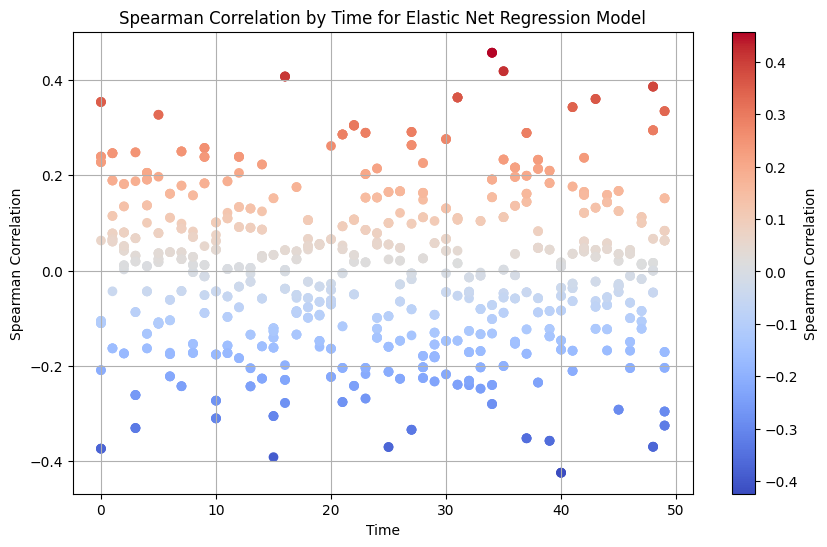

In [73]:

correlations = [result[2] for result in saved_data['results']]
timepoints = [result[1] for result in saved_data['results']]

# Create DataFrame (assuming Spearman correlation)
data = {'time': timepoints, 'correlation': correlations}
df = pd.DataFrame(data)


# Create scatter plot with color representing correlation
plt.figure(figsize=(10, 6))
plt.scatter(df['time'], df['correlation'], c=df['correlation'], cmap='coolwarm')  # Adjust colormap as needed
plt.colorbar(label='Spearman Correlation')  # Add colorbar for legend
plt.xlabel('Time')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by Time for Elastic Net Regression Model')
plt.grid(True)
plt.show()